In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from scipy.stats import multivariate_normal
from scipy.sparse import spdiags
from scipy.sparse import kron
from mpl_toolkits.mplot3d import Axes3D
import time
import random
from sklearn.decomposition import PCA, NMF
import scipy.sparse as sp
import scipy.linalg as linalg
from numpy.random import default_rng

## Arbitary Number of Gaussian Mixtures

$$\rho(x, \vec{w}, \vec{\mu}) = \sum_{i=1}^k N(x; \mu_k, I)$$

In [2]:
##define the the mixture of gaussian function 
##it takes k: number of mixtures
##x -- 2d vector, the position in 2d plane
##vec mu k pairs of means
##vec w k-1 weight parameters
def model(x, k, mu, w):
    result = 0;
    for i in range(k-1):
        result = result + w[i]*multivariate_normal.pdf(x, mean=mu[i], cov=[[0.3, 0], [0, 0.3]]);
    w_last = 1 - np.sum(w);
    result = result + w_last*multivariate_normal.pdf(x, mean=mu[k-1], cov=[[0.3, 0], [0, 0.3]]);
    return result;

#it generates and returns random parameters:
#[k-1 weight paras, k means]
def generate_random_para(k):
    mu_x = 0; mu_y = 0;
    if (k<=90):
        mu_x = np.array(random.sample(range(5, 95), k))/10;
        mu_y = np.array(random.sample(range(5, 95), k))/10;
    else:
        mu_x = np.array(random.sample(range(50, 950), k))/100;
        mu_y = np.array(random.sample(range(50, 950), k))/100;
    means = [];
    for i in range(k):
        means.append(np.array([mu_x[i], mu_y[i]]));
    means = np.array(means);
    weights = [random.randrange(40, 60) for i in range(k)];
    weights = np.array(weights);
    weights = weights/np.sum(weights);
    weights = weights[0:k-1];
    return [means, weights];  


Now Discretize the $[0, 10] \times [0, 10]$ area into 31 by 31 grid squares.

Define the truth distribution and compute the values on these 900 interior grid points.

In [3]:
#fix k = 20 now
dx = 10/31; dy = 10/31;
X = [];
for i in range(1, 31):
    for j in range(1, 31):
        X.append([dx*i, dy*j]);
X = np.array(X);

## Define the $L_2$ loss function $U(\theta)$

In [4]:
#X is the mesh grid points we want to evaluate at
#mu, w is the current parameters
#ytruth is the truth values
def loss(X, k, mu, w, ytruth):
    ymodel = model(X, k, mu, w);
    error = 0.5*(ytruth-ymodel)**2;
    return np.sum(error);

In [6]:
k = 200;
[mu_true, w_true] = generate_random_para(k);
[mu, w] = generate_random_para(k);
ytruth = model(X, k, mu_true, w_true)

start = time.time();
loss(X, k, mu, w, ytruth)
end = time.time();
print(end - start)



0.029211997985839844


## Take the Derivative of $\rho$
w.r.t w:
$$\frac{d\rho}{dw_i} = N(x; \mu_i, I) - N(x; \mu_k, I)$$
for $i = 1, 2, 3, ..., k-1$

w.r.t $\mu$:
$$\frac{d\rho}{d\mu_i} = -w_i\frac{1}{2\pi}(\mu_i -x)exp\{ -\frac{1}{2}(x-\mu_i)^T(x-\mu_i) \} = -w_i(\mu_i -x)N(x; \mu_i, I)$$
for $i = 1, 2, 3, ..., k-1$
$$\frac{d\rho}{d\mu_k} = (\sum_{i=1}^{k-1}w_i -1)\frac{1}{2\pi}(\mu_k -x)exp\{ -\frac{1}{2}(x-\mu_k)^T(x-\mu_k) \} = (\sum_{i=1}^{k-1}w_i -1)(\mu_k -x)N(x; \mu_k, I)$$

In [5]:
def expinner(x, mu):
    inner = -0.5*np.einsum("ij, ij->i", x-mu, x-mu);
    return np.exp(inner);  

##it returns the gradient of p w.r.t all the w_i
##returns a matrix of size (N-1)^2*(k-1)
def dpdw(x, mu, w, k):
    result = [];
    for i in range(k-1):
        result.append(multivariate_normal.pdf(x, mean=mu[i], cov=[[1, 0], [0, 1]]));
    result = result - multivariate_normal.pdf(x, mean=mu[k-1], cov=[[1, 0], [0, 1]]);
    result = np.array(result);
    result = np.transpose(result);
    return result;

In [6]:
#the derivative dp/dmu1:
def dpdmu(w, x, mu):
    t1 = expinner(x, mu); t2 = (mu-x);
    return -w*(1/(2*np.pi))*np.multiply(t2, t1[:, np.newaxis]);

In [7]:
#it returns a (N-1)^2 by 3k-1 matrix
def p_grad(X, mu, w, k, N):
    result = np.zeros(((N-1)**2, 3*k-1));
    result[:, 0:k-1] = dpdw(X, mu, w, k);
    for i in range(k-1):
        result[:, 2*i+k-1:2*i+k+1] = dpdmu(w[i], X, mu[i]);
    w_last = 1- np.sum(w);
    result[:, 3*k-3:3*k-1] = dpdmu(w_last, X, mu[k-1]);
    return result;

#it returns a (N-1)^2 by 2k matrix
#which is the gradient w.r.t mus only
def p_grad_mu(X, mu, w, k, N):
    result = np.zeros(((N-1)**2, 2*k));
    for i in range(k-1):
        result[:, 2*i:2*i+2] = dpdmu(w[i], X, mu[i]);
    w_last = 1- np.sum(w);
    result[:, 2*k-2:2*k] = dpdmu(w_last, X, mu[k-1]);
    return result;

#it returns the gradient of p together with the gradient of U
#returns [p_grad, u_grad]
def U_grad(X, mu, w, k, N, ytruth):
    p = model(X, k, mu, w) - ytruth;
    P = p_grad(X, mu, w, k, N);
    Q = p.T @ P;
    return [P, Q];

Discretization:

In [8]:
#compute the matrix A that represents the process of taking divergence
#returns a 2*(N-1)**2 by (N-1)**2 matrix
def discretize(N, dx, dy):
    ones = np.ones(N-1);
    diags = np.array([-1, 1]);
    data = [-ones, ones];
    B = spdiags(data, diags, N-1, N-1).toarray();
    I = np.identity(N-1);
    A1 = kron(I, B).toarray()/(2*dx);
    A2 = kron(B, I).toarray()/(2*dy);
    return np.concatenate((A1, A2), axis=0);

In [9]:
##compute the matrix sigma
def sigma(X, N, w, mu, k):
    diagonal = 1/model(X, k, mu, w);
    data = np.array([diagonal]);
    diags = np.array([0]);
    sig = spdiags(data, diags, (N-1)**2, (N-1)**2).toarray();
    return sig;

##compute the matrix big sigma
##that is a concatenation of sigma
def Sigma(X, N, w, mu, k):
    sig = sigma(X, N, w, mu, k);
    I = np.identity(2);
    Sig = kron(I, sig).toarray();
    return Sig;

##compute the matrix C
def Cmatrix(X, N, w, mu, k):
    C = Sigma(X, N, w, mu, k);
    C = 2*C;
    C = np.linalg.inv(C);
    return C;

First, let's fix all the means and let the k-1 weights be the only parameters.

We wish to compute the matrix $G_w \in R^{(k-1) \times (k-1)}$

$$M = -CA(A^TCA)^{-1}\rho_{\vec{w}}$$
$$G_w = M^T Sig M$$

In [10]:
#the function that only computes the matrix G w.r.t only w
def Gmatrix_w(X, N, mu, w, k, A):
    Sig = Sigma(X, N, w, mu, k);
    C = 2*Sig; C = np.linalg.inv(C);
    CA = np.matmul(C, A);
    ACAinv = np.linalg.inv(np.matmul(np.transpose(A), CA));
    K = np.matmul(CA, ACAinv);
    P = dpdw(X, mu, w, k);
    M = -np.matmul(K, P);
    G = np.matmul(np.transpose(M), np.matmul(Sig, M));
    return G;

In [13]:
num = np.array([5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 100, 150, 200, 300]);
explained_ratio = [];
A = discretize(31, dx, dy);
for i in range(16):
    k = num[i];
    [means, ws] = generate_random_para(k);
    G = Gmatrix_w(X, 31, means, ws, k, A);
    pca = PCA(n_components = k-1);
    pca.fit(G);
    pv = pca.explained_variance_ratio_;
    explained_ratio.append(pv);

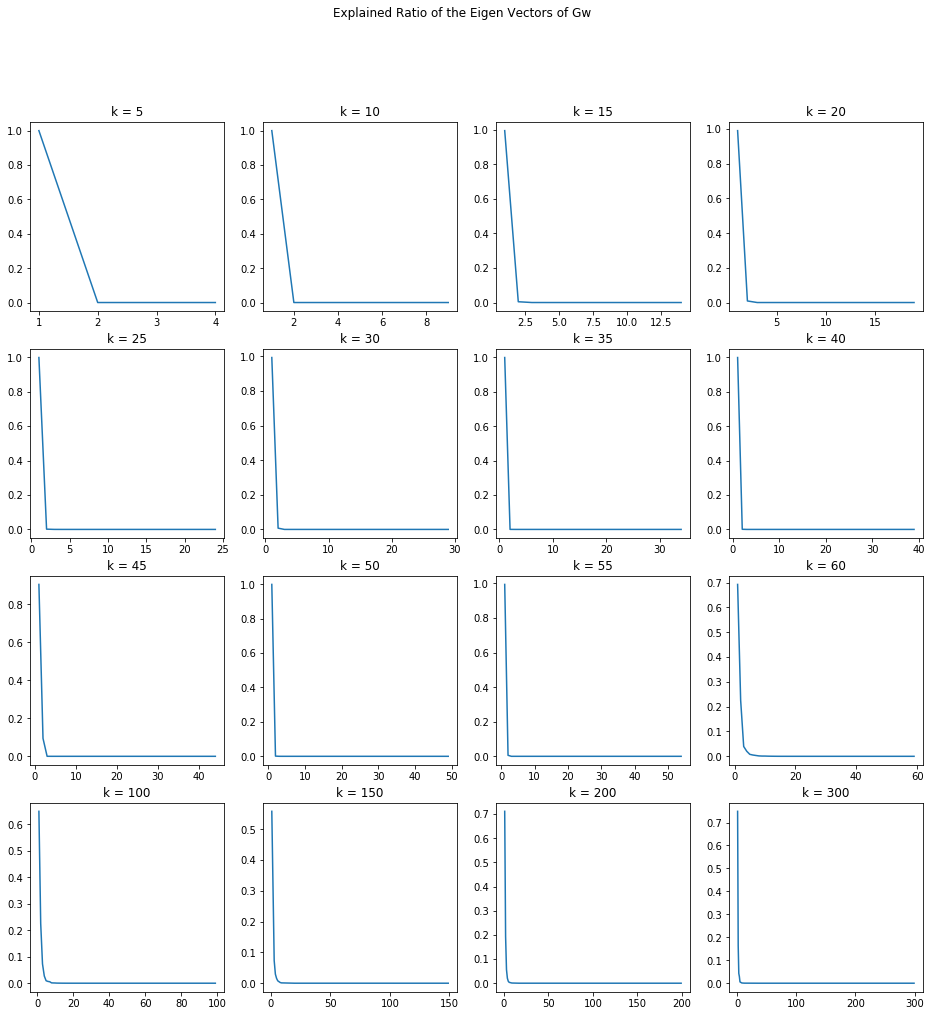

In [14]:
#plot the explained ratios
fig, ax = plt.subplots(4, 4, figsize=(16, 16));
for i in range(4):
    for j in range(4):
        k = 4*i+j;
        ax[i][j].plot([i for i in range(1, num[k])], explained_ratio[k]);
        ax[i][j].set_title("k = {}".format(num[k]));
fig.suptitle("Explained Ratio of the Eigen Vectors of Gw");
plt.savefig("/Users/leiwanzhou/Desktop/evd_G.jpg", dpi=200)

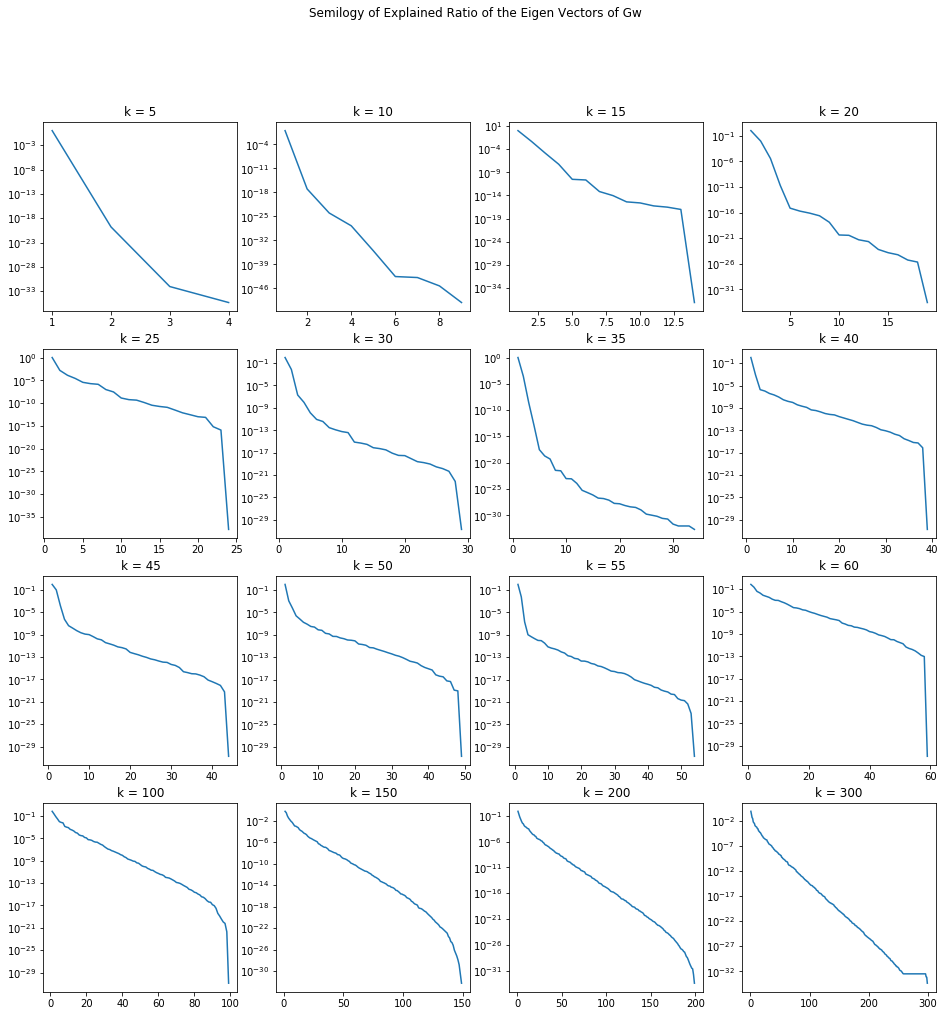

In [15]:
#semilogy of the explained ratio
fig, ax = plt.subplots(4, 4, figsize=(16, 16));
for i in range(4):
    for j in range(4):
        k = 4*i+j;
        ax[i][j].semilogy([i for i in range(1, num[k])], explained_ratio[k]);
        ax[i][j].set_title("k = {}".format(num[k]));
fig.suptitle("Semilogy of Explained Ratio of the Eigen Vectors of Gw");
plt.savefig("/Users/leiwanzhou/Desktop/semilogy_evd_G.jpg", dpi=200)

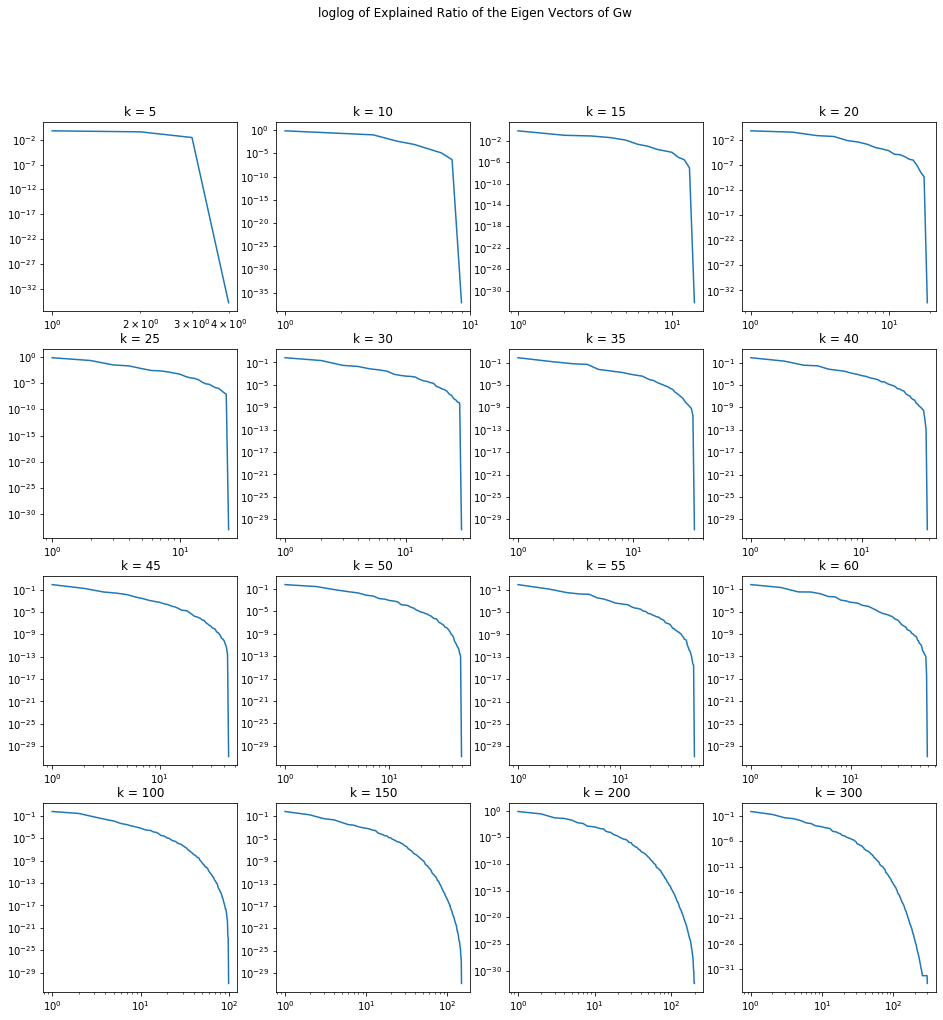

In [38]:
#plot the log log explained ratios
fig, ax = plt.subplots(4, 4, figsize=(16, 16));
for i in range(4):
    for j in range(4):
        k = 4*i+j;
        ax[i][j].loglog([i for i in range(1, num[k])], explained_ratio[k]);
        ax[i][j].set_title("k = {}".format(num[k]));
fig.suptitle("loglog of Explained Ratio of the Eigen Vectors of Gw");
plt.savefig("/Users/leiwanzhou/Desktop/loglog_evd_G.jpg", dpi=200)

Then, let's fix all the weights and let 2k mean parameters be the only parameters.

We wish to compute the matrix $G_\mu \in R^{2k \times 2k}$

$$M = -CA(A^TCA)^{-1}\rho_{\vec{\mu}}$$
$$G_w = M^T Sig M$$

In [11]:
#the function that only computes the matrix G w.r.t only mu
def Gmatrix_mu(X, N, mu, w, k, A):
    Sig = Sigma(X, N, w, mu, k);
    C = 2*Sig; C = np.linalg.inv(C);
    CA = np.matmul(C, A);
    ACAinv = np.linalg.inv(np.matmul(np.transpose(A), CA));
    K = np.matmul(CA, ACAinv);
    P = p_grad_mu(X, mu, w, k, N);
    M = -np.matmul(K, P);
    G = np.matmul(np.transpose(M), np.matmul(Sig, M));
    return G;

In [12]:
num = np.array([5, 10, 15, 20, 23, 25, 30, 35, 40, 45, 50, 60, 100, 150, 200, 300]);
explained_ratio = [];
A = discretize(31, dx, dy);
for i in range(16):
    k = num[i];
    [means, ws] = generate_random_para(k);
    G = Gmatrix_mu(X, 31, means, ws, k, A);
    pca = PCA(n_components = 2*k);
    pca.fit(G);
    pv = pca.explained_variance_ratio_;
    explained_ratio.append(pv);

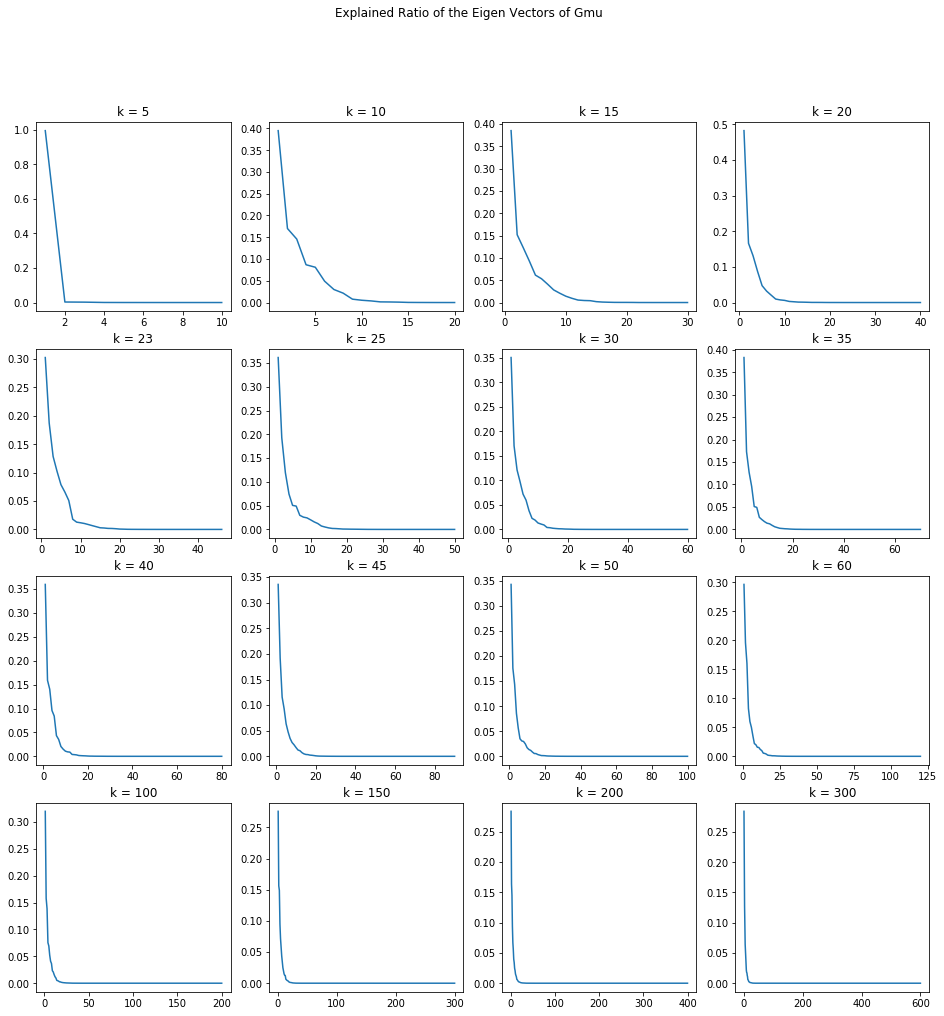

In [31]:
#plot the explained ratios
fig, ax = plt.subplots(4, 4, figsize=(16, 16));
for i in range(4):
    for j in range(4):
        k = 4*i+j;
        ax[i][j].plot([i for i in range(1, 2*num[k]+1)], explained_ratio[k]);
        ax[i][j].set_title("k = {}".format(num[k]));
fig.suptitle("Explained Ratio of the Eigen Vectors of Gmu");
plt.savefig("/Users/leiwanzhou/Desktop/evd_Gmu.jpg", dpi=200)

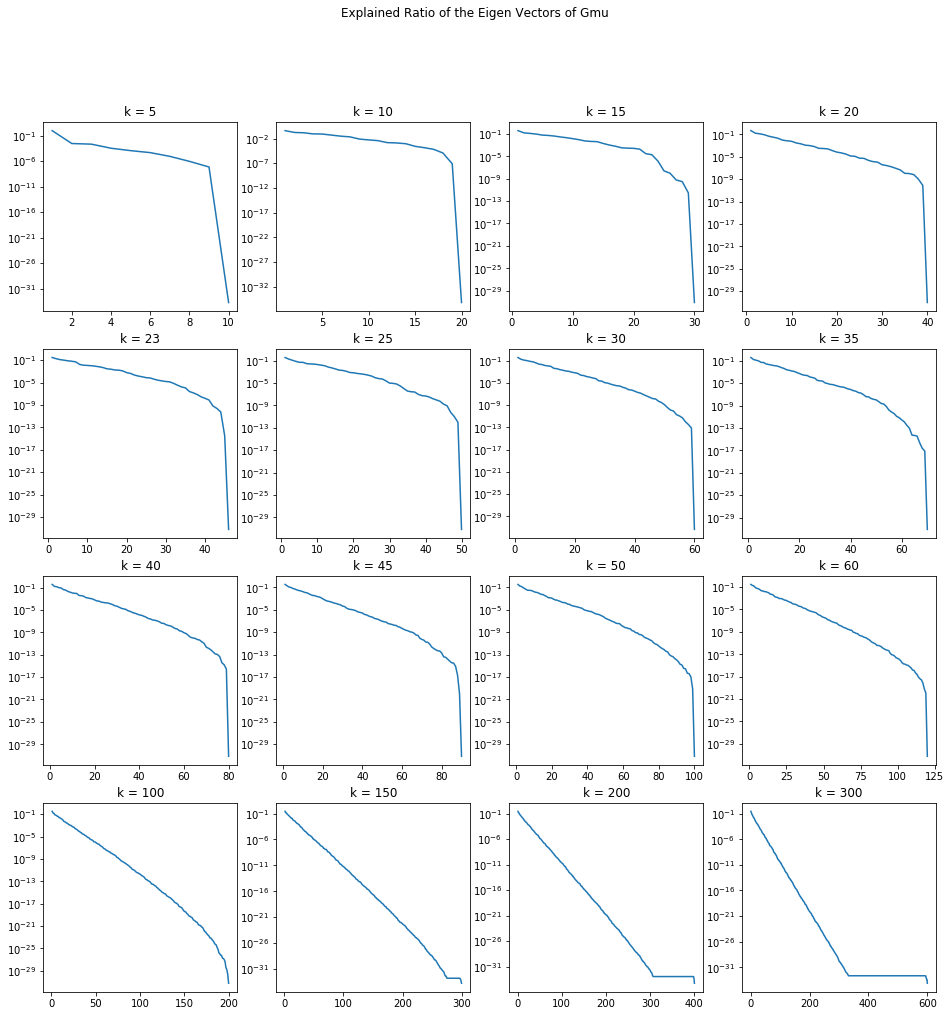

In [32]:
#plot the explained ratios
fig, ax = plt.subplots(4, 4, figsize=(16, 16));
for i in range(4):
    for j in range(4):
        k = 4*i+j;
        ax[i][j].semilogy([i for i in range(1, 2*num[k]+1)], explained_ratio[k]);
        ax[i][j].set_title("k = {}".format(num[k]));
fig.suptitle("Explained Ratio of the Eigen Vectors of Gmu");
plt.savefig("/Users/leiwanzhou/Desktop/semilogy_evd_Gmu.jpg", dpi=200)

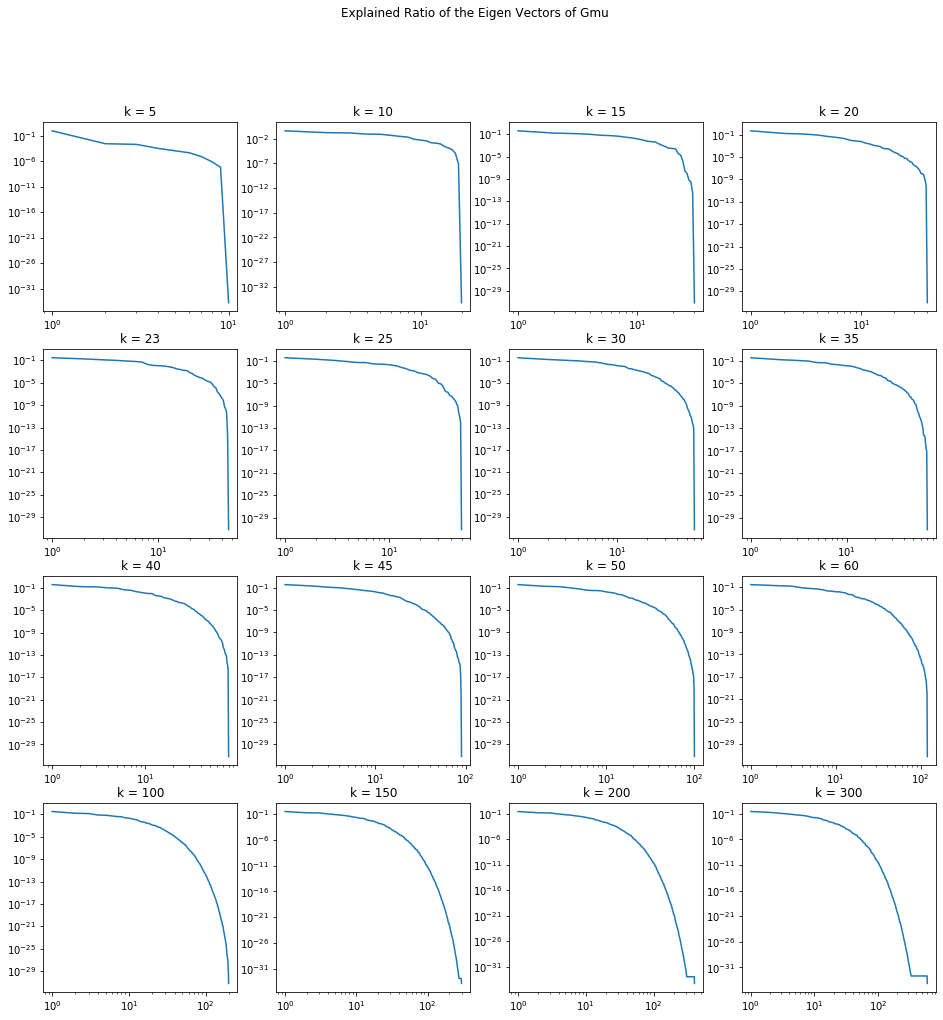

In [33]:
#plot the explained ratios
fig, ax = plt.subplots(4, 4, figsize=(16, 16));
for i in range(4):
    for j in range(4):
        k = 4*i+j;
        ax[i][j].loglog([i for i in range(1, 2*num[k]+1)], explained_ratio[k]);
        ax[i][j].set_title("k = {}".format(num[k]));
fig.suptitle("Explained Ratio of the Eigen Vectors of Gmu");
plt.savefig("/Users/leiwanzhou/Desktop/loglog_evd_Gmu.jpg", dpi=200)

Don't fix anything. The k mixtures have 3k-1 parameters in total.

Compute the matrix $$G \in R^{(3k-1) \times (3k-1)}$$

$$M = -CA(A^TCA)^{-1}\rho_{\vec{\theta}}$$
$$G_w = M^T Sig M$$

In [12]:
#the function that computes the matrix G w.r.t all the parameters
def Gmatrix(X, N, mu, w, k, A):
    Sig = Sigma(X, N, w, mu, k);
    C = 2*Sig; C = np.linalg.inv(C);
    CA = np.matmul(C, A);
    ACAinv = np.linalg.inv(np.matmul(np.transpose(A), CA));
    K = np.matmul(CA, ACAinv);
    P = p_grad(X, mu, w, k, N);
    M = -np.matmul(K, P);
    G = np.matmul(np.transpose(M), np.matmul(Sig, M));
    return G;

In [407]:
num = np.array([2, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 60, 70, 80, 90, 100]);
explained_ratio = [];
A = discretize(31, dx, dy);
for i in range(16):
    k = num[i];
    [means, ws] = generate_random_para(k);
    G = Gmatrix(X, 31, means, ws, k, A);
    pca = PCA(n_components = 3*k-1);
    pca.fit(G);
    pv = pca.explained_variance_ratio_;
    explained_ratio.append(pv);

0.3957829475402832
0.4979820251464844
0.5097191333770752
0.47874021530151367
0.4326140880584717
0.4362680912017822
0.4243779182434082
0.41709017753601074
0.4395277500152588
0.4560110569000244
0.4459381103515625
0.4537017345428467
0.46294403076171875
0.46254611015319824
0.44416284561157227
0.47490811347961426


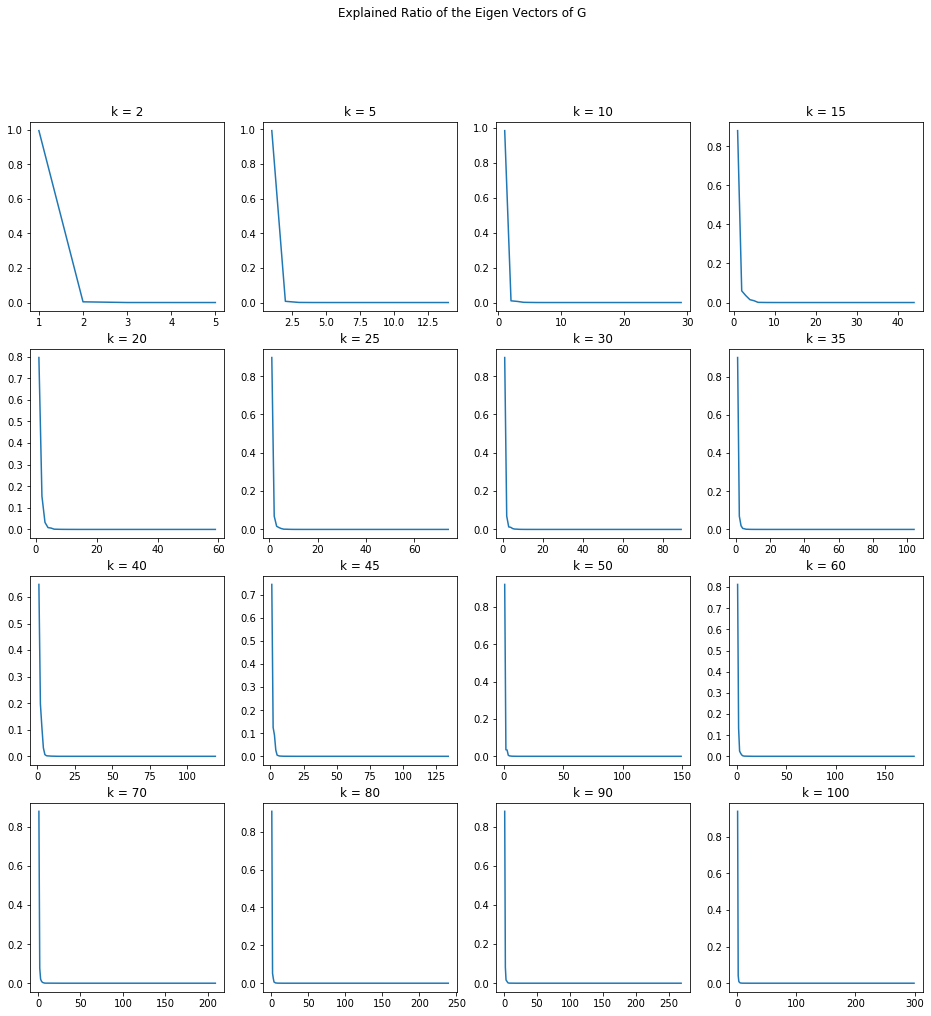

In [47]:
#plot the explained ratios
fig, ax = plt.subplots(4, 4, figsize=(16, 16));
for i in range(4):
    for j in range(4):
        k = 4*i+j;
        ax[i][j].plot([i for i in range(1, 3*num[k])], explained_ratio[k]);
        ax[i][j].set_title("k = {}".format(num[k]));
fig.suptitle("Explained Ratio of the Eigen Vectors of G");
plt.savefig("/Users/leiwanzhou/Desktop/evd_Gmuall.jpg", dpi=200)

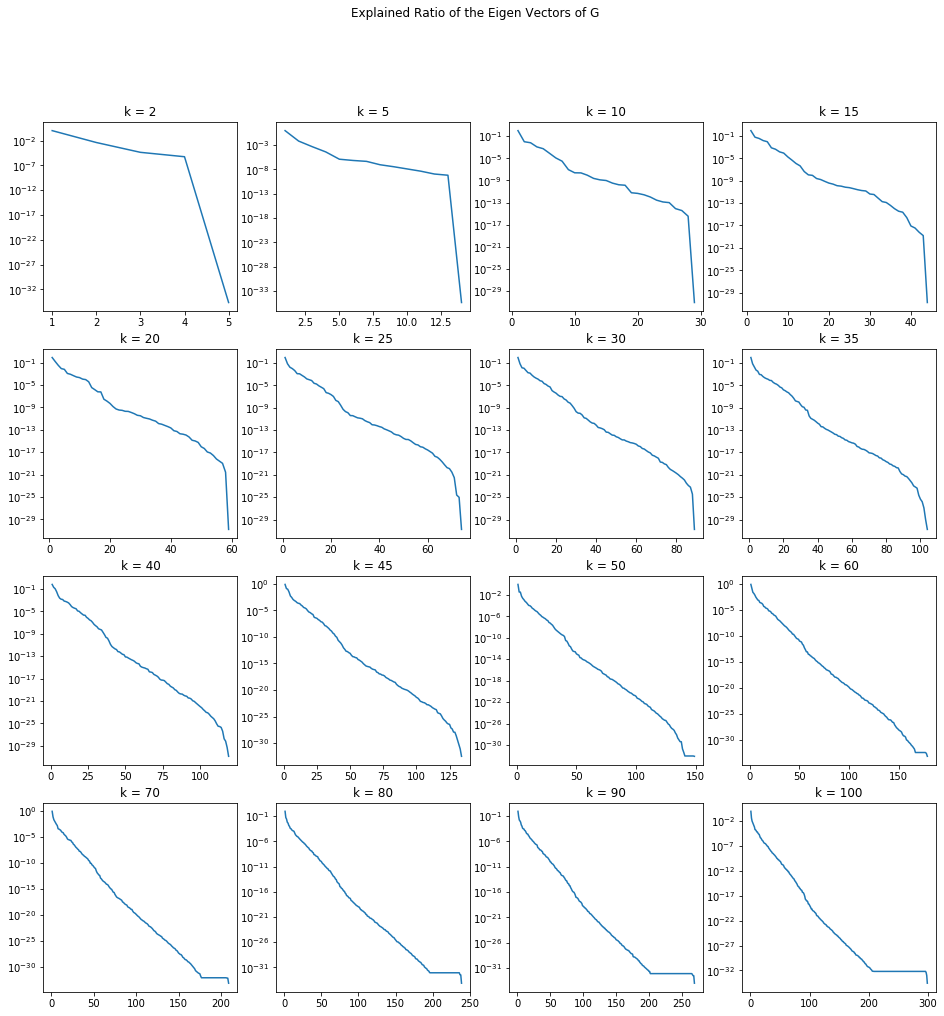

In [48]:
#plot the explained ratios
fig, ax = plt.subplots(4, 4, figsize=(16, 16));
for i in range(4):
    for j in range(4):
        k = 4*i+j;
        ax[i][j].semilogy([i for i in range(1, 3*num[k])], explained_ratio[k]);
        ax[i][j].set_title("k = {}".format(num[k]));
fig.suptitle("Explained Ratio of the Eigen Vectors of G");
plt.savefig("/Users/leiwanzhou/Desktop/semilogy_evd_Gmuall.jpg", dpi=200)

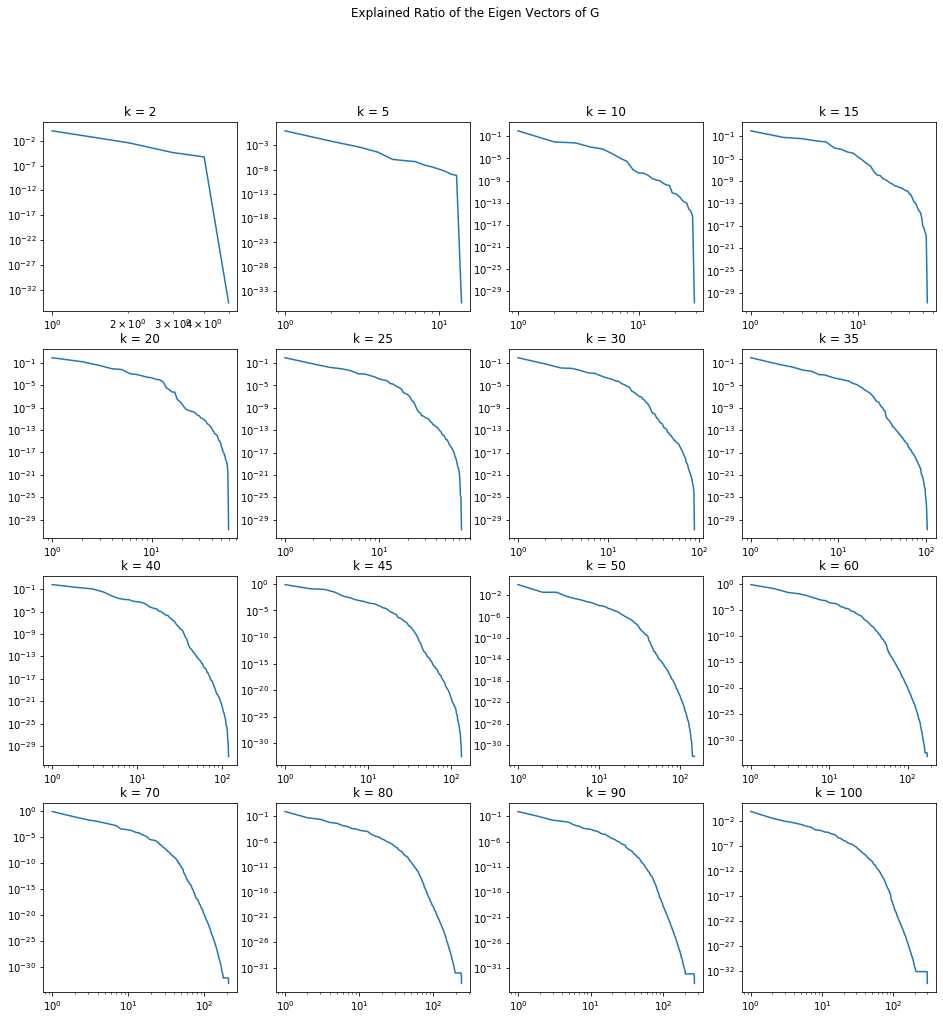

In [49]:
#plot the explained ratios
fig, ax = plt.subplots(4, 4, figsize=(16, 16));
for i in range(4):
    for j in range(4):
        k = 4*i+j;
        ax[i][j].loglog([i for i in range(1, 3*num[k])], explained_ratio[k]);
        ax[i][j].set_title("k = {}".format(num[k]));
fig.suptitle("Explained Ratio of the Eigen Vectors of G");
plt.savefig("/Users/leiwanzhou/Desktop/loglog_evd_Gmuall.jpg", dpi=200)

In [54]:
K = np.array([2, 5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 150, 200, 300]);
A = discretize(31, dx, dy);
speeds = [];
for j in range(K.shape[0]):
    print(K[j]);
    [means, ws] = generate_random_para(K[j]);
    start = time.time();
    for i in range(100):
        G = Gmatrix(X, 31, means, ws, K[j], A);
    end = time.time();
    spd = (end-start)/100;
    speeds.append(spd)
    print("k = {} , Average G matrix time: {} seconds".format(K[j] ,spd));

2
k = 2 , Average G matrix time: 0.4311316728591919 seconds
5
k = 5 , Average G matrix time: 0.44492342948913577 seconds
10
k = 10 , Average G matrix time: 0.42207645893096923 seconds
20
k = 20 , Average G matrix time: 0.4362840986251831 seconds
30
k = 30 , Average G matrix time: 0.44362028121948244 seconds
40
k = 40 , Average G matrix time: 0.4578261876106262 seconds
50
k = 50 , Average G matrix time: 0.4630570697784424 seconds
60
k = 60 , Average G matrix time: 0.4610497307777405 seconds
70
k = 70 , Average G matrix time: 0.4902780890464783 seconds
80
k = 80 , Average G matrix time: 0.4896394109725952 seconds
90
k = 90 , Average G matrix time: 0.4745268106460571 seconds
100
k = 100 , Average G matrix time: 0.4864096212387085 seconds
150
k = 150 , Average G matrix time: 0.5236985087394714 seconds
200
k = 200 , Average G matrix time: 0.5655842614173889 seconds
300
k = 300 , Average G matrix time: 0.7009838581085205 seconds


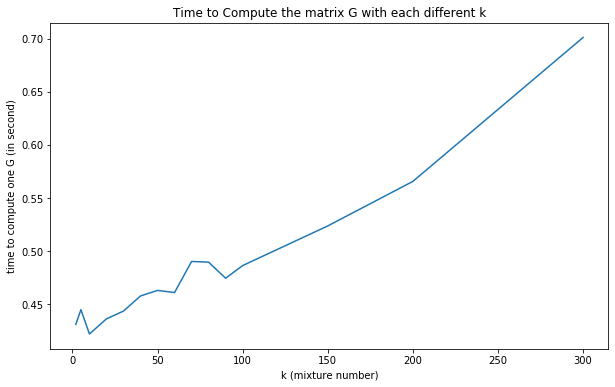

In [55]:
plt.plot(K, speeds)
plt.rcParams['figure.figsize'] = [10, 6]
plt.title("Time to Compute the matrix G with each different k")
plt.xlabel("k (mixture number)")
plt.ylabel("time to compute one G (in second)")
plt.savefig("/Users/leiwanzhou/Desktop/speed_G_2-300.jpg", dpi=200)

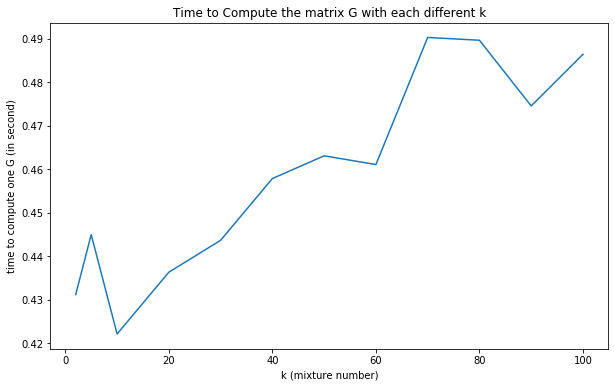

In [56]:
plt.plot(K[0:12], speeds[0:12])
plt.rcParams['figure.figsize'] = [10, 6]
plt.title("Time to Compute the matrix G with each different k")
plt.xlabel("k (mixture number)")
plt.ylabel("time to compute one G (in second)")
plt.savefig("/Users/leiwanzhou/Desktop/speed_G_2-100.jpg", dpi=200)

## Approximate the matrix $G_{w^2}$

Compute the matrix B
$$B = AP^{-1}$$
where
$$A = [A_1^T A_2^T] \in R^{(N-1)^2 \times 2(N-1)^2}$$
$$P = \sqrt{C}$$

In [13]:
#it returns a bsr_matrix
def Bmatrix(X, N, w, mu, k, A):
    A = sp.bsr_matrix(A.T);
    diagonal = model(X, k, mu, w)**0.5;
    if (np.isnan(np.sum(diagonal))):
        for i in range(diagonal.shape[0]):
            if (np.isnan(diagonal[i])):
                print("i: {}".format(i));
        return -1;
    data = np.array([diagonal]);
    diags = np.array([0]);
    sig = spdiags(data, diags, (N-1)**2, (N-1)**2);
    I = sp.identity(2);
    Pinv = kron(I, sig);
    B = A@Pinv;
    return B;

def permute_row(A, perm):
    size = perm.size;
    Aprime = np.zeros(A.shape);
    for i in range(1, size):
        Aprime[perm[i]] = A[perm[i-1]];
    Aprime[perm[0]] = A[perm[size-1]];
    return Aprime;

def permute_col(A, perm):
    size = perm.size;
    Aprime = np.zeros(A.shape);
    for i in range(1, size):
        Aprime[:, perm[i]] = A[:, perm[i-1]];
    Aprime[:, perm[0]] = A[:, perm[size-1]];
    return Aprime;

Do column-pivoting QR factorization on the matrix B to obtain:
$$BPerm = QR$$

In [14]:
k = 30;
[mu, w] = generate_random_para(k)
A = discretize(31, dx, dy)

In [15]:
##this one does the approximation
def Gmatrix_appr(X, N, w, mu, k, A, m):
#     start = time.time();
    B = Bmatrix(X, N, w, mu, k, A).toarray();
    q, r= linalg.qr(B.T, mode = 'economic')
    grad = p_grad(X, mu, w, k, N);
    Z = np.linalg.solve(r.T, -grad);
    Y = np.matmul(q, Z)
    Q, R, P = linalg.qr(Y, mode = 'economic', pivoting = True);
    Rtil = R[0:m, :];
    inv = np.empty_like(P);
    inv[P] = np.arange(len(inv), dtype=inv.dtype);
    U = Rtil.T[inv, :];
    G = U @ U.T;
#     end = time.time();
#     print("entire time: {}".format(end - start));
    return [G, Y];

In [16]:
#this one does not do the approximation, computes R^T R directly
##this one does the approximation
def Gmatrix_appr2(X, N, w, mu, k, A):
    start = time.time();
    B = Bmatrix(X, N, w, mu, k, A).toarray();
    q, r= linalg.qr(B.T, mode = 'economic')
    grad = p_grad(X, mu, w, k, N);
    Z = np.linalg.solve(r.T, -grad);
    Y = np.matmul(q, Z)
    Q, R = linalg.qr(Y, mode = 'economic');
    G = R.T @ R;
    end = time.time();
    print("entire time: {}".format(end - start));
    return [G, Y, Q, R];

In [17]:
#with approximation
G_appr, Y = Gmatrix_appr(X, 31, w, mu, k, A, 3*k)
G = Gmatrix(X, 31, mu, w, k, A);
print("The distance between G appr and true G:");
print(np.linalg.norm(G_appr - G));
print("The distance between Y^TY and true G:");
print(np.linalg.norm((Y.T @ Y) - G));
print("The distance between Y^TY and U U^T:");
print(np.linalg.norm((Y.T @ Y) - G_appr));

The distance between G appr and true G:
7.782994069586286e-12
The distance between Y^TY and true G:
7.2055680544057554e-12
The distance between Y^TY and U U^T:
2.264216173785919e-12


In [18]:
#no approximation
G_appr, Y, Q, R= Gmatrix_appr2(X, 31, w, mu, k, A)
G = Gmatrix(X, 31, mu, w, k, A);
print("The distance between G appr and true G:");
print(np.linalg.norm(G_appr - G));
print("The distance between Y^TY and true G:");
print(np.linalg.norm((Y.T @ Y) - G));

entire time: 0.18218111991882324
The distance between G appr and true G:
8.024500576056645e-12
The distance between Y^TY and true G:
7.2055680544057554e-12


## Compute the Natural Gradient Descent Direction Directly

Option 1:

We are given the matrix Y.
    
Apply QR factorization on Y:
$$Y = QR$$
then we know:
$$G_{w_2} = Y^TY = R^T Q^T QR = R^T R$$
The natural gradient descent algorithm:
$$\theta^{(l+1)} = \theta^{(l)} - \eta_l G_{w_2}^{-1} \nabla U(\theta_{(l)})$$
We want to compute the natural gradient descent direction $x = G_{w_2}^{-1} \nabla U(\theta_{(l)})$, which is the solution of
$$G_{w_2}x = \nabla U(\theta_{(l)})$$
which is equivelent to:
$$R^T R x = \nabla U(\theta_{(l)})$$
substitude $z = Rx$. Solve the linear equation:
$$R^T z = \nabla U(\theta_{(l)})$$
since $R$ is upper trangular, this will only take $O(n^2)$
then we solve the linear equation:
$$Rx = z$$
since $R$ is upper trangular, this will also only take $O(n^2)$

In [19]:
def Natural_dir1(X, N, k, w, mu, ytruth, A):
    B = Bmatrix(X, N, w, mu, k, A).toarray();
    q, r= linalg.qr(B.T, mode = 'economic');
    p_grad, u_grad = U_grad(X, mu, w, k, N, ytruth);
    Z = np.linalg.solve(r.T, -p_grad);
    Y = np.matmul(q, Z)
    Q, R = linalg.qr(Y, mode = 'economic')
    z = np.linalg.solve(R.T, u_grad);
    x = np.linalg.solve(R, z);
    return x;

Option 2: Do some approximation on G

Apply QR factorization on Y and we get:
$$Y = QR$$
Similarly we want to solve the following linear system to get the direction x:
$$R^T R x = \nabla U(\theta_{(l)})$$
where $R \in R^{p \times p}$ and p is the number of parameters.

Do a quick sort on the absolute values of the diagonal of R in descending order and reorder the rows of R and only save the first k rows to obtain:
$$\tilde{R} \in R^{k \times p}$$
Now the direction can be approximated by solveing:
$$\tilde{R}^T \tilde{R} x = \nabla U(\theta^{(l)})$$
Then we apply an economic qr factorization on matrix $\tilde{R}^T$:
$$\tilde{R}^T = Q_1 R_1$$
Then we have:
$$Q_1R_1 R_1^T Q_1^T x = \nabla U(\theta^{(l)})$$
$$R_1R_1^T Q_1^T x = Q_1^T \nabla U(\theta^{(l)})$$
Let $y = Q_1^T x$ we want to solve:
$$R_1R_1^T y = Q_1^T \nabla U(\theta^{(l)})$$
Set $z = R_1^T y$, solve:
$$R_1 z = Q_1^T \nabla U(\theta^{(l)})$$
then solve:
$$R_1^T y = z$$
and finally set:
$$x = Q_1y$$

In [20]:
def quick_sort(numseq, indexseq):
    size = len(numseq);
    if (size<=1):
        return [numseq, indexseq];
    pivot = size//2;
    pivotvalue = numseq.pop(pivot);
    midnum = [pivotvalue];
    midindex = [indexseq.pop(pivot)];
    leftnum = []; rightnum = [];
    leftindex = []; rightindex = [];
    for i in range(size-1):
        if (numseq[i] > pivotvalue):
            leftnum.append(numseq[i]);
            leftindex.append(indexseq[i]);
        else:
            rightnum.append(numseq[i]);
            rightindex.append(indexseq[i]);
    sortednuml, sortedindexl = quick_sort(leftnum, leftindex);
    sortednumr, sortedindexr = quick_sort(rightnum, rightindex);
    return [sortednuml+midnum+sortednumr, sortedindexl+midindex+sortedindexr];

In [21]:
#m is the order of apprximation, the less m is, the quicker the algo 
#but less accurate the return value is
#m must be <= 3k-1
def Natural_dir2(X, N, k, w, mu, ytruth, A, m):
    B = Bmatrix(X, N, w, mu, k, A);
    if (type(B)==int):
        return -1;
    B = B.toarray();
    q, r= linalg.qr(B.T, mode = 'economic');
    gradp, gradu = U_grad(X, mu, w, k, N, ytruth);
    Z = np.linalg.solve(r.T, -gradp);
    Y = np.matmul(q, Z)；
    Q, R = linalg.qr(Y, mode = 'economic')
    diag = abs(np.diagonal(R))
    numseq, indexseq = quick_sort(list(diag), list(range(len(diag))))
    Rtil = R[indexseq[0:m], :]
    Q1, R1 = linalg.qr(Rtil.T, mode = 'economic');
    z = np.linalg.solve(R1, Q1.T @ gradu);
    y = np.linalg.solve(R1.T, z);
    x = Q1 @ y;
    return x;

Option 3:

Approximate the natural gradient direction:

Apply QR factorization on Y and we get:
$$Y = QR$$
Similarly we want to solve the following linear system to get the direction x:
$$R^T R x = \nabla U(\theta_{(l)})$$
where $R \in R^{p \times p}$ and p is the number of parameters.
We apply an eigen value decomposition on matrix R and obtain:
$$[\Lambda, X] = eig(R)$$
where $\Lambda \in R^p$ is all the p eigen values of the matrix R and $X \in R^{p\times p}$ is all the corresponding eigenvectors in the columns. Let's put $\Lambda$ on the diagonal of a matrix and obtain matrix $\Phi$ we have:
$$RX = X\Phi$$
therefore, 
$$R = X\Phi X^T$$
$$R^T R = X \Phi^T X^T X \Phi X^T = X \Phi^T\Phi X^T$$
We want to solve:
$$X \Phi^T\Phi X^T x = \nabla U(\theta_{(l)})$$
which is equivalent to:
$$X \Phi^2 X^T x = \nabla U(\theta_{(l)})$$
Take the first k rows of $X$ to obatain $\tilde{X}$ and take the first k cols and rows of $\Phi$ to obtain $\tilde{\Phi}$
$$\tilde{X} \tilde{\Phi}^2 \tilde{X}^T x = \nabla U(\theta_{(l)})$$
solve this we get:
$$x = \tilde{X}(\tilde{\Phi}^2)^{-1}\tilde{X}^T \nabla U(\theta_{(l)})$$

In [22]:
def Natural_dir3(X, N, k, w, mu, ytruth, A, m):
    B = Bmatrix(X, N, w, mu, k, A).toarray();
    q, r= linalg.qr(B.T, mode = 'economic');
    gradp, gradu = U_grad(X, mu, w, k, N, ytruth);
    Z = np.linalg.solve(r.T, -gradp);
    Y = np.matmul(q, Z)
    Q, R = linalg.qr(Y, mode = 'economic')
    [landa, X2] = sp.linalg.eigs(R, k = m);
    landa = landa**(-2);
    data = landa
    diags = np.array([0]);
    phi = spdiags(data, diags, m, m);
    x = X2 @ phi @ X2.T @ gradu;
    return x;
    

In [31]:
gradp, gradu = U_grad(X, mu, w, k, 31, ytruth);
true_dir = np.linalg.inv(Gmatrix(X, 31, mu, w, k, A))@gradu
dir1 = Natural_dir1(X, 31, k, w, mu, ytruth, A)
dir2 = Natural_dir2(X, 31, k, w, mu, ytruth, A, 3*k-1)
dir3 = Natural_dir3(X, 31, k, w, mu, ytruth, A, 3*k-1)

/Users/leiwanzhou/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/linalg/eigen/arpack/arpack.py:1254: RuntimeWarning: k >= N - 1 for N * N square matrix. Attempting to use scipy.linalg.eig instead.
  RuntimeWarning)


In [32]:
print(np.linalg.norm(true_dir-dir1, ord = 2));
print(np.linalg.norm(true_dir-dir2, ord = 2));
print(np.linalg.norm(true_dir-dir3, ord = 2));

0.0004755643682795938
0.000475564432465298
38.99065644234349


In [553]:
K = [2, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100];
dir1grade = [];
dir2grade = [];
dir3grade = [];
for k in K:
    grade1 = 0; grade2 = 0; grade3 = 0;
    for i in range(10):
        [mu, w] = generate_random_para(k);
        gradp, gradu = U_grad(X, mu, w, k, 31, ytruth);
        true_dir = np.linalg.inv(Gmatrix(X, 31, mu, w, k, A))@gradu
        dir1 = Natural_dir1(X, 31, k, w, mu, ytruth, A)
        dir2 = Natural_dir2(X, 31, k, w, mu, ytruth, A, 3*k-1)
        dir3 = Natural_dir3(X, 31, k, w, mu, ytruth, A, 3*k-1)
        grade1 = grade1 + np.linalg.norm(true_dir - dir1);
        grade2 = grade2 + np.linalg.norm(true_dir - dir2);
        grade3 = grade3 + np.linalg.norm(true_dir - dir3);
    dir1grade.append(np.linalg.norm(grade1/10));
    dir2grade.append(np.linalg.norm(grade2/10));
    dir3grade.append(np.linalg.norm(grade3/10));

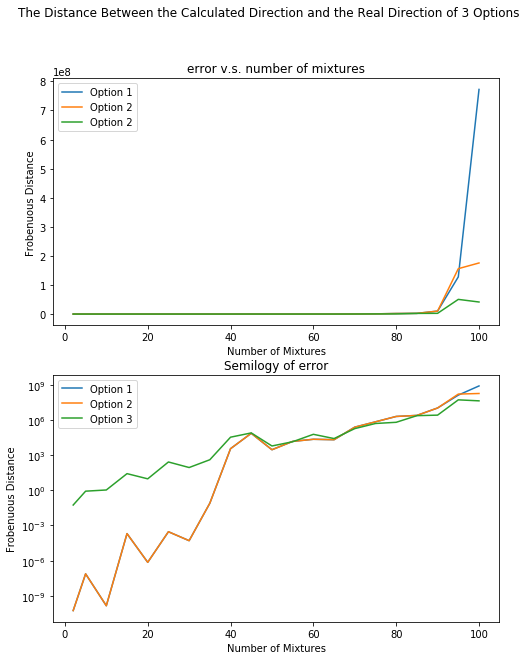

In [555]:
fig, ax = plt.subplots(2, 1, figsize=(8, 10));
ax[0].plot(K, dir1grade, label = 'Option 1')
ax[0].plot(K, dir2grade, label = 'Option 2')
ax[0].plot(K, dir3grade, label = 'Option 2')
ax[0].set_title("error v.s. number of mixtures")
ax[0].set_xlabel("Number of Mixtures")
ax[0].set_ylabel("Frobenuous Distance")
ax[0].legend()
ax[1].semilogy(K, dir1grade, label = 'Option 1')
ax[1].semilogy(K, dir2grade, label = 'Option 2')
ax[1].semilogy(K, dir3grade, label = 'Option 3')
ax[1].set_title("Semilogy of error")
ax[1].set_xlabel("Number of Mixtures")
ax[1].set_ylabel("Frobenuous Distance")
ax[1].legend()
fig.suptitle("The Distance Between the Calculated Direction and the Real Direction of 3 Options");
plt.savefig("/Users/leiwanzhou/Desktop/errors_3Options.jpg", dpi=200)

In [217]:
K = [5, 20, 40, 60, 80, 100, 125, 150, 175, 200, 250, 300, 350, 400, 450, 500];
Gappr_grade = [];
for k in K:
    grade = 0;
    for i in range(5):
        [mu, w] = generate_random_para(k);
        trueG = Gmatrix(X, 31, mu, w, k, A);
        Gappr, Y_, = Gmatrix_appr(X, 31, w, mu, k, A, 2*k);
        grade = grade + np.linalg.norm(trueG - Gappr, ord = 2);
    Gappr_grade.append(grade/5)

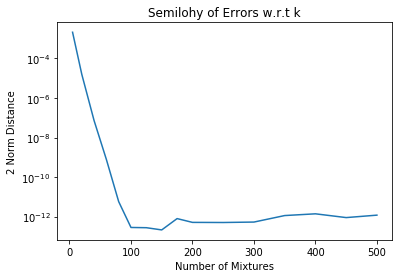

In [218]:
plt.semilogy(K, Gappr_grade)
plt.title("Semilohy of Errors w.r.t k")
plt.xlabel("Number of Mixtures");
plt.ylabel("2 Norm Distance")
plt.savefig("/Users/leiwanzhou/Desktop/errors_Gappr_2norm_2korder", dpi=200)

In [43]:
k = 100;
grade = [];
index = [];
[mu, w] = generate_random_para(k);
trueG = Gmatrix(X, 31, mu, w, k, A);
for m in range(5, 3*k-1, 2):
    index.append(m);
    Gappr, Y_= Gmatrix_appr(X, 31, w, mu, k, A, m);
    grade.append(np.linalg.norm(trueG - Gappr, ord = 2));

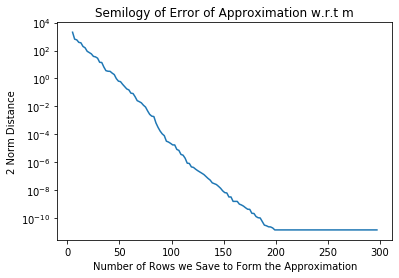

In [44]:
plt.semilogy(index, grade)
plt.title("Semilogy of Error of Approximation w.r.t m")
plt.xlabel("Number of Rows we Save to Form the Approximation")
plt.ylabel("2 Norm Distance")
plt.savefig("/Users/leiwanzhou/Desktop/errors_Gappr_wrtm_2norm", dpi=200)

## Compute the Angle Between the Real and Empirical Descant Direction

In [31]:
def cos(v1, v2):
    innerpro = np.inner(v1, v2);
    normpro = np.linalg.norm(v1, ord = 2)*np.linalg.norm(v2, ord = 2);
    return innerpro/normpro;

In [308]:
K = [2, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100];
dir1grade = [];
dir2grade = [];
for k in K:
    print(k)
    grade1 = 0; grade2 = 0; grade3 = 0;
    for i in range(1):
        [mu, w] = generate_random_para(k);
        gradp, gradu = U_grad(X, mu, w, k, 31, ytruth);
        true_dir = np.linalg.inv(Gmatrix(X, 31, mu, w, k, A))@gradu
        dir1 = Natural_dir1(X, 31, k, w, mu, ytruth, A)
        dir2 = Natural_dir2(X, 31, k, w, mu, ytruth, A, 2*k);
        grade1 = grade1 + cos(true_dir, dir1);
        grade2 = grade2 + cos(true_dir, dir2);
    dir1grade.append(np.linalg.norm(grade1));
    dir2grade.append(np.linalg.norm(grade2));

2
5
10
15
20
25
30
35
40
45
50
55
60
65
70
75
80
85
90
95
100


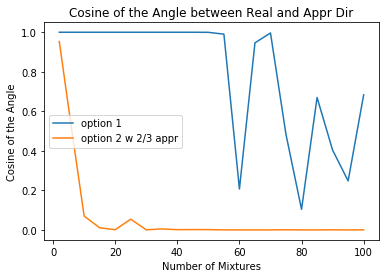

In [309]:
plt.plot(K, dir1grade, label = 'option 1');
plt.plot(K, dir2grade, label = 'option 2 w 2/3 appr');
plt.title("Cosine of the Angle between Real and Appr Dir")
plt.xlabel("Number of Mixtures")
plt.ylabel("Cosine of the Angle")
plt.legend();
plt.savefig("/Users/leiwanzhou/Desktop/angle_2-3appr.jpg", dpi=200)

## Try Gradient Descent in High Dimension:
let's start with 30 mixtures.

In [23]:
k = 30;

In [24]:
#generate the truth parameters
[mu_true, w_true] = generate_random_para(k);
ytruth = model(X, k, mu_true, w_true)

In [25]:
##define 2 functions that transfer parameters from 2 vectors to 1 single vector
def to1(mu, w):
    return np.concatenate((w, mu.flatten()))

def to2(para, k):
    w = para[0:k-1];
    mu = para[k-1:3*k-1];
    return [w, np.reshape(mu, (-1, 2))];

#define a function that check the weights of the model 
#they should be in the range 0 ~ 2/k
#if not, manually set it to 1/k
#lastly check if the sum of k-1 weights is less then 1
#if not decrease all weights such that their sum is 29/30
def check_weights(para, k):
    for i in range(k-1):
        if (para[i] <= 0 or para[i] >= 2/k):
            para[i] = 1/k;
    summ = np.sum(para[0:k-1]);
    if (summ >= 1):
        para[0:k-1] = para[0:k-1] - (summ-1+1/k)/(k-1);
    return para;

In [76]:
#presearve 2 thirds of the rows
def GD_dir2(N, k, initial_para, para_true, ytruth, lr, iteration):
    para = initial_para; 
    w_initial, mu_initial = to2(initial_para, k);
    loss_trace = [loss(X, k, mu_initial, w_initial, ytruth)];
    diff_norm = [np.linalg.norm(para-para_true)];
    start = time.time();
    for i in range(iteration):
        print(i);
        w, mu = to2(para, k);
        dir2 = Natural_dir2(X, 31, k, w, mu, ytruth, A, 2*k);
        if (type(dir2)==int):
            break;
        para = para - lr*dir2;
        loss_trace.append(loss(X, k, mu, w, ytruth));
        diff_norm.append(np.linalg.norm(para-para_true));
    end = time.time();
    print("Time each iteration: {}".format((end-start)/iteration));
    fig, ax = plt.subplots(1, 2, figsize=(14, 5));
    ax[0].plot(loss_trace/loss_trace[0]);
    fig.suptitle("The Normalized Loss Trace of Gradient Descent with dir2 with Appr 2/3");
    ax[0].set_xlabel("Number of Iterations");
    ax[0].set_ylabel("Loss")
    ax[1].semilogy(loss_trace/loss_trace[0]);
    ax[1].set_xlabel("Number of Iterations");
    ax[1].set_ylabel("Loss")
    w_true, mu_true = to2(para_true, k);
    w_final, mu_final = to2(para, k);
    plt.figure(figsize=(12, 12));
    plt.scatter(mu_true[:, 0], mu_true[:, 1], label = 'True Para', alpha = '0.5')
    plt.scatter(initial_mu[:, 0], initial_mu[:, 1], label = 'Starting Para', c = 'r', alpha = 0.5)
    plt.scatter(mu_final[:, 0], mu_final[:, 1], label = 'Final Para', c = 'g')
    plt.title("The True, Starting and Final position of Means")
    plt.legend()
    plt.figure(figsize=(10, 5));
    plt.plot(diff_norm);
    plt.title("Norm of the Difference");
    plt.xlabel("Iteration");
    plt.ylabel("L2 distance");
    return [loss_trace, para, diff_norm];

def std_GD(N, k, initial_para, para_true, ytruth, lr, iteration):
    para = initial_para; 
    w_initial, mu_initial = to2(initial_para, k);
    loss_trace = [loss(X, k, mu_initial, w_initial, ytruth)];
    diff_norm = [np.linalg.norm(para-para_true)];
    start = time.time();
    for i in range(iteration):
        w, mu = to2(para, k);
        P, dir2 = U_grad(X, mu, w, k, N, ytruth);
        if (type(dir2)==int):
            break;
        para = para - lr*dir2;
        loss_trace.append(loss(X, k, mu, w, ytruth));
        diff_norm.append(np.linalg.norm(para-para_true));
    end = time.time();
    print("Time each iteration: {}".format((end-start)/iteration));
    fig, ax = plt.subplots(1, 2, figsize=(14, 5));
    ax[0].plot(loss_trace/loss_trace[0]);
    fig.suptitle("The Normalized Loss Trace of Gradient Descent with dir2 with Appr 2/3");
    ax[0].set_xlabel("Number of Iterations");
    ax[0].set_ylabel("Loss")
    ax[1].semilogy(loss_trace/loss_trace[0]);
    ax[1].set_xlabel("Number of Iterations");
    ax[1].set_ylabel("Loss")
    w_true, mu_true = to2(para_true, k);
    w_final, mu_final = to2(para, k);
    plt.figure(figsize=(12, 12));
    plt.scatter(mu_true[:, 0], mu_true[:, 1], label = 'True Para', alpha = '0.5')
    plt.scatter(initial_mu[:, 0], initial_mu[:, 1], label = 'Starting Para', c = 'r', alpha = 0.5)
    plt.scatter(mu_final[:, 0], mu_final[:, 1], label = 'Final Para', c = 'g')
    plt.title("The True, Starting and Final position of Means")
    plt.legend()
    plt.figure(figsize=(10, 5));
    plt.plot(diff_norm);
    plt.title("Norm of the Difference");
    plt.xlabel("Iteration");
    plt.ylabel("L2 distance");
    return [loss_trace, para, diff_norm];

In [27]:
#perturb the value of the true parameters a little bit as the starting parameter value
initial_para1 = to1(mu_true, w_true);
initial_para1[29] += 1;
initial_w1, initial_mu1 = to2(initial_para1, 30);
loss(X, 30, initial_mu1, initial_w1, ytruth)

0.0018920442318022279

In [28]:
loss_trace1, final_para1 = GD_dir2(31, k, initial_para1, ytruth, 0.1, 100)

0
[0.03623188 0.03623188 0.03293808 0.03557312 0.03096179 0.03886693
 0.03623188 0.02700922 0.03754941 0.0342556  0.02964427 0.0342556
 0.03491436 0.0342556  0.03096179 0.03557312 0.0342556  0.03293808
 0.02635046 0.03689065 0.0342556  0.03030303 0.0342556  0.03227931
 0.03030303 0.03689065 0.02964427 0.03030303 0.02898551]
[[7.  5.8]
 [4.7 5.1]
 [7.7 9.3]
 [6.3 8.1]
 [6.5 6.3]
 [0.6 6.4]
 [6.9 0.9]
 [8.6 7.5]
 [2.9 2.4]
 [8.9 4.4]
 [3.9 2.5]
 [6.6 6.8]
 [1.9 8. ]
 [6.1 2.2]
 [8.2 7.6]
 [2.2 6.9]
 [2.  8.7]
 [3.4 3.7]
 [2.8 4.1]
 [4.9 5.6]
 [8.4 6.2]
 [7.2 2.1]
 [1.4 4.8]
 [8.1 3.1]
 [3.8 2.7]
 [7.9 4.6]
 [3.6 7.8]
 [8.7 0.7]
 [4.  7.2]
 [5.5 8.5]]
1
[0.03050141 0.03462409 0.03283819 0.03784156 0.03897329 0.03894548
 0.03614589 0.0267898  0.0379961  0.03365491 0.02898907 0.02862658
 0.03326626 0.03355623 0.03074425 0.03559165 0.03526741 0.03161633
 0.02833194 0.03786602 0.03561781 0.03183828 0.03367307 0.03021526
 0.03115833 0.04018551 0.02936466 0.03027373 0.02911962]
[[6.98826572 5.8

9
[0.00821832 0.02957904 0.03190678 0.04342808 0.06609361 0.03959609
 0.03704441 0.02603204 0.03956524 0.03504022 0.02850198 0.01380576
 0.03344423 0.03292687 0.032455   0.03424225 0.03574149 0.03198819
 0.02920076 0.0403631  0.04086249 0.03262222 0.0331582  0.02643749
 0.03072769 0.04391853 0.02896722 0.03014338 0.02879158]
[[6.97166158 5.82483057]
 [4.71579715 5.16843126]
 [7.69208572 9.38223266]
 [6.33840872 8.04858469]
 [6.52443088 6.24740218]
 [0.64763737 6.41054098]
 [6.88411633 0.92676792]
 [8.59359369 7.53611798]
 [2.910506   2.40943797]
 [8.8565148  4.40228028]
 [3.92291873 2.49784777]
 [6.64197741 6.8049456 ]
 [1.88225643 8.0122729 ]
 [6.08812405 2.20584347]
 [8.20923159 7.59883657]
 [2.21589412 6.90808989]
 [2.01922539 8.67802169]
 [3.42926147 3.70726839]
 [2.81733255 4.16675267]
 [4.91933858 5.49786738]
 [8.2996732  6.19452438]
 [7.21820966 2.16855012]
 [1.35680509 4.79784811]
 [8.20610936 2.98448574]
 [3.81925108 2.71817353]
 [7.84562231 4.54626504]
 [3.63406654 7.73000315

17
[0.00453277 0.02594318 0.03175248 0.04469821 0.06872618 0.03931062
 0.03834987 0.0228225  0.03960397 0.03578971 0.03104054 0.01293325
 0.03812718 0.03212533 0.03622286 0.03245147 0.03320351 0.0349001
 0.02756941 0.0430489  0.04112559 0.03142311 0.03343904 0.02643907
 0.02696268 0.04411371 0.02844172 0.0301776  0.02965446]
[[6.96181565 5.81641375]
 [4.73125448 5.16202267]
 [7.70946343 9.40351048]
 [6.35123315 8.01963401]
 [6.50949408 6.22416056]
 [0.64306367 6.40526146]
 [6.88163387 0.96350797]
 [8.59253284 7.52366799]
 [2.91126883 2.40878026]
 [8.86328838 4.41017851]
 [3.93211019 2.5011434 ]
 [6.64077914 6.81088944]
 [1.90487526 7.99377922]
 [6.08397952 2.21189144]
 [8.20219864 7.58452178]
 [2.21764579 6.86306936]
 [2.01076987 8.70963211]
 [3.40205977 3.69194682]
 [2.84292282 4.18576673]
 [4.93658069 5.48410016]
 [8.33727612 6.20373244]
 [7.21558795 2.19252886]
 [1.3667612  4.78580007]
 [8.20842435 2.97245857]
 [3.81367398 2.71644852]
 [7.81323046 4.53270634]
 [3.63169073 7.73565732

25
[0.00049777 0.02372735 0.03170001 0.04540575 0.07384123 0.03912532
 0.03887317 0.02179484 0.0395384  0.03589994 0.03157545 0.0099296
 0.03918941 0.03234223 0.03764786 0.0323154  0.03258018 0.03594365
 0.02690774 0.04506093 0.04138371 0.03030858 0.0335714  0.02672325
 0.02616567 0.04467795 0.02888084 0.03014544 0.02919332]
[[6.96175236 5.816397  ]
 [4.73607076 5.15908032]
 [7.71837062 9.40170923]
 [6.3567038  8.01012749]
 [6.50614226 6.22130026]
 [0.63242622 6.40214619]
 [6.89028591 0.9694192 ]
 [8.59436832 7.51174458]
 [2.91079719 2.40877011]
 [8.86812805 4.4151404 ]
 [3.9312495  2.50116413]
 [6.64090121 6.81149985]
 [1.90778045 7.9895844 ]
 [6.08804767 2.20464584]
 [8.19563742 7.57778668]
 [2.21626716 6.84776215]
 [2.00785969 8.71826616]
 [3.39990754 3.68990031]
 [2.84851034 4.19511663]
 [4.94620116 5.47894184]
 [8.34615031 6.20941321]
 [7.21265238 2.21024435]
 [1.37438969 4.78041681]
 [8.19821179 2.96922654]
 [3.81125702 2.71505092]
 [7.80748169 4.529997  ]
 [3.62786814 7.73274352

34
[-0.00185198  0.02165264  0.03173087  0.04540939  0.07675086  0.03885277
  0.03908706  0.02089243  0.03949111  0.03585183  0.03162339  0.00832452
  0.03901023  0.03270802  0.03883392  0.03278797  0.03255332  0.03630968
  0.02659642  0.04729207  0.04140099  0.0294787   0.03368992  0.02713473
  0.02614785  0.04492266  0.02966267  0.03009672  0.02842852]
[[6.96175869 5.81639847]
 [4.73808258 5.1579895 ]
 [7.72052987 9.39297009]
 [6.35406046 8.00162033]
 [6.50369233 6.22066455]
 [0.61835647 6.39972715]
 [6.90018899 0.96718906]
 [8.59543313 7.50504117]
 [2.910341   2.40893363]
 [8.86908079 4.41965951]
 [3.9298352  2.50098663]
 [6.64047629 6.81169343]
 [1.90665022 7.99026026]
 [6.09398544 2.19547374]
 [8.1921091  7.57692721]
 [2.20581235 6.84174482]
 [2.00565705 8.71772083]
 [3.40122519 3.69161114]
 [2.85098325 4.1986261 ]
 [4.95313156 5.47540802]
 [8.35992585 6.21347532]
 [7.20792763 2.22238809]
 [1.38166785 4.7768519 ]
 [8.18718297 2.97313982]
 [3.8103258  2.71426784]
 [7.80956335 4.529

42
[-0.00313897  0.02018138  0.03179651  0.0452225   0.07831186  0.03864297
  0.03918788  0.02039297  0.03944566  0.03583153  0.03154817  0.00750278
  0.03859678  0.0330025   0.03950342  0.03325558  0.03267547  0.0363843
  0.02645434  0.04903186  0.04134045  0.02891063  0.03376638  0.02750273
  0.02633492  0.04494907  0.03032603  0.0300597   0.02775175]
[[6.96177353 5.81640178]
 [4.73879102 5.15769959]
 [7.71948318 9.38401161]
 [6.35007613 7.9954221 ]
 [6.50211051 6.22087346]
 [0.60771507 6.39798665]
 [6.90722709 0.96462012]
 [8.59610561 7.50142401]
 [2.90996219 2.40898027]
 [8.86866522 4.42345018]
 [3.9287382  2.50087414]
 [6.64006697 6.81175458]
 [1.9053067  7.99197752]
 [6.09883187 2.18893252]
 [8.190251   7.57807266]
 [2.19587565 6.83935741]
 [2.00412887 8.71495222]
 [3.40219232 3.69324894]
 [2.85171247 4.19899756]
 [4.95711288 5.47351362]
 [8.37085437 6.21576522]
 [7.20446469 2.22966277]
 [1.38690776 4.77477235]
 [8.17827171 2.97750923]
 [3.81005039 2.7138797 ]
 [7.81280701 4.5291

50
[-0.00404131  0.01900393  0.0318798   0.04502127  0.07939287  0.03847578
  0.0392564   0.02013189  0.03939017  0.03585958  0.03144266  0.0069368
  0.03818006  0.03324527  0.03988585  0.03365776  0.03282282  0.03636639
  0.02636186  0.05052146  0.04125754  0.02845328  0.03382122  0.02784178
  0.02657488  0.04486798  0.03087825  0.03003165  0.02715815]
[[6.96178821 5.81640504]
 [4.73912751 5.15762482]
 [7.71713314 9.37546181]
 [6.34615995 7.99008958]
 [6.50084694 6.22129576]
 [0.59937418 6.39636753]
 [6.91257074 0.96275766]
 [8.59667602 7.49890582]
 [2.90956957 2.40892118]
 [8.86798184 4.42692374]
 [3.92771023 2.5007449 ]
 [6.63970255 6.811787  ]
 [1.90422203 7.99380687]
 [6.10280895 2.18395624]
 [8.1889504  7.57978597]
 [2.18694757 6.83796149]
 [2.00296586 8.71181963]
 [3.4024957  3.69440847]
 [2.85174269 4.19812019]
 [4.9598624  5.47230582]
 [8.37987027 6.21724436]
 [7.20197876 2.23484403]
 [1.39126395 4.77325004]
 [8.17025808 2.98154188]
 [3.80989727 2.71359345]
 [7.81588613 4.5288

58
[-0.00470498  0.01805511  0.0319708   0.04485095  0.08017774  0.0383468
  0.03929906  0.02004798  0.03932635  0.03592277  0.03132483  0.00651905
  0.03780608  0.03343961  0.04005858  0.0339855   0.03296996  0.03630718
  0.02629024  0.05179547  0.04116436  0.0280941   0.03386191  0.02814344
  0.02683127  0.04472669  0.03130703  0.03001179  0.0266677 ]
[[6.9618011  5.81640799]
 [4.73931938 5.15761939]
 [7.7141406  9.36774794]
 [6.34267839 7.98548306]
 [6.49980592 6.22176745]
 [0.593118   6.39477018]
 [6.91652416 0.96151909]
 [8.59717806 7.49709279]
 [2.90915242 2.40879921]
 [8.86745315 4.43000783]
 [3.9266573  2.50055176]
 [6.63939278 6.81180801]
 [1.90334034 7.99552651]
 [6.10587084 2.18021903]
 [8.18800479 7.58164868]
 [2.17926866 6.83719673]
 [2.00220105 8.70875996]
 [3.40227727 3.69516327]
 [2.85140585 4.19658304]
 [4.96185924 5.47149792]
 [8.38721631 6.21817087]
 [7.20032552 2.23834971]
 [1.39501174 4.77206542]
 [8.16315131 2.98519227]
 [3.80972747 2.71332921]
 [7.81857832 4.5284

66
[-0.0052062   0.01728164  0.03206381  0.04472017  0.08076023  0.03824794
  0.03931739  0.02009086  0.03925814  0.03600694  0.03120195  0.00620062
  0.03747442  0.03359365  0.04008212  0.03425133  0.03311324  0.03622931
  0.02622733  0.05289294  0.04106427  0.02782271  0.03389471  0.02840689
  0.02708885  0.0445545   0.03162316  0.02999839  0.02627767]
[[6.9618119  5.81641059]
 [4.7394553  5.15762952]
 [7.71086347 9.36092271]
 [6.33967565 7.98151363]
 [6.49893667 6.22223225]
 [0.58856295 6.39318179]
 [6.91941502 0.96067252]
 [8.59762248 7.49577648]
 [2.90871409 2.40865914]
 [8.86722658 4.43269213]
 [3.92553532 2.50027879]
 [6.63913292 6.81182255]
 [1.90252772 7.997097  ]
 [6.1081183  2.17739754]
 [8.18731981 7.58348973]
 [2.17271919 6.83699146]
 [2.00183897 8.7058635 ]
 [3.40174845 3.69567129]
 [2.85087681 4.19468801]
 [4.96338389 5.47092341]
 [8.39323592 6.21872364]
 [7.19930951 2.2404843 ]
 [1.39832578 4.77112432]
 [8.1569235  2.98854887]
 [3.80950489 2.7130579 ]
 [7.82091324 4.528

74
[-0.00559143  0.01664379  0.03215559  0.04462542  0.08119726  0.03817139
  0.03931382  0.02022278  0.03918945  0.03610249  0.03107983  0.00595428
  0.0371745   0.03371561  0.04000092  0.03447003  0.03325432  0.03614395
  0.02616821  0.0538467   0.04095875  0.02762666  0.03392386  0.02863464
  0.02733765  0.04436861  0.03184433  0.02998975  0.02597679]
[[6.96182067 5.81641285]
 [4.7395701  5.15763634]
 [7.70750811 9.35491193]
 [6.33710261 7.97810209]
 [6.49820594 6.22267256]
 [0.58533017 6.39162497]
 [6.92151699 0.96004452]
 [8.59801551 7.49482465]
 [2.90826378 2.40853481]
 [8.8673131  4.43500358]
 [3.92433823 2.49993026]
 [6.63891502 6.81183237]
 [1.90168299 7.99852943]
 [6.10970341 2.1752364 ]
 [8.18683671 7.58523801]
 [2.16710043 6.83731172]
 [2.00185217 8.70312584]
 [3.40108126 3.69605826]
 [2.85024341 4.19259812]
 [4.96460008 5.47048764]
 [8.39822011 6.21902666]
 [7.1987579  2.24152966]
 [1.40129898 4.77039195]
 [8.151518   2.99167462]
 [3.80923702 2.7127754 ]
 [7.82295525 4.527

82
[-0.0058918   0.01611216  0.03224421  0.0445599   0.08152713  0.03811085
  0.03929171  0.02041587  0.03912339  0.0362035   0.03096381  0.00576257
  0.03689609  0.03381265  0.03984734  0.0346539   0.03339529  0.03605713
  0.02611114  0.05468274  0.04084912  0.02749258  0.03395191  0.02883067
  0.02756991  0.04417895  0.03198847  0.02998449  0.02575166]
[[6.96182766 5.81641478]
 [4.73967749 5.15763422]
 [7.70419602 9.34961146]
 [6.33488934 7.97517655]
 [6.49758922 6.2230851 ]
 [0.58309792 6.39012917]
 [6.92304015 0.95953176]
 [8.59836217 7.49414836]
 [2.90781205 2.40844818]
 [8.86767014 4.43698423]
 [3.92307973 2.49951965]
 [6.63873141 6.81183824]
 [1.90074947 7.99984573]
 [6.11078205 2.17354842]
 [8.18651398 7.5868677 ]
 [2.16222662 6.83811142]
 [2.00219418 8.70052371]
 [3.40039573 3.69640561]
 [2.84954781 4.19040645]
 [4.9656058  5.47013639]
 [8.40239215 6.21916379]
 [7.19853306 2.24173803]
 [1.40397837 4.76985519]
 [8.14686199 2.9946007 ]
 [3.80894629 2.71248796]
 [7.82475716 4.527

90
[-0.0061293   0.01566478  0.03232852  0.04451681  0.08177699  0.03806164
  0.03925471  0.02064959  0.03906221  0.03630642  0.03085843  0.00561332
  0.03663168  0.0338906   0.03964506  0.03481211  0.0335374   0.03597237
  0.02605573  0.05542154  0.04073683  0.0274078   0.03398022  0.02899933
  0.02777969  0.04399115  0.03207141  0.02998154  0.02558941]
[[6.96183313 5.81641639]
 [4.73978281 5.1576223 ]
 [7.70099821 9.34492133]
 [6.33296887 7.97267352]
 [6.49706741 6.22347154]
 [0.58160967 6.38871861]
 [6.92414092 0.95907912]
 [8.59866677 7.4936866 ]
 [2.9073685  2.40841163]
 [8.86824109 4.43867827]
 [3.92178078 2.49906301]
 [6.6385756  6.81184064]
 [1.89970474 8.00106696]
 [6.11149162 2.17220047]
 [8.18632111 7.58837464]
 [2.15794812 6.8393307 ]
 [2.0028108  8.6980364 ]
 [3.39976902 3.69676056]
 [2.84880972 4.18816974]
 [4.96646196 5.46983791]
 [8.40591976 6.21919083]
 [7.19853056 2.24132266]
 [1.40638956 4.76950518]
 [8.14287703 2.99734035]
 [3.8086569  2.71220481]
 [7.82635597 4.526

99
[-0.00634108  0.01524156  0.03241741  0.044488    0.0819869   0.03801576
  0.03919961  0.02094237  0.03900099  0.03642186  0.03075675  0.00548512
  0.03634515  0.03396117  0.03938069  0.03496747  0.0336991   0.03588206
  0.02599552  0.05615656  0.04060916  0.02735752  0.03401305  0.0291615
  0.0279838   0.04378596  0.03210787  0.02998     0.02546788]
[[6.96183778 5.81641786]
 [4.73990128 5.15759814]
 [7.6975864  9.34026741]
 [6.33108759 7.97029405]
 [6.49657481 6.22387895]
 [0.5805797  6.38725285]
 [6.92501677 0.95860925]
 [8.59896394 7.49337098]
 [2.90688899 2.40843681]
 [8.86907176 4.44029147]
 [3.92029791 2.49851321]
 [6.63842709 6.81183963]
 [1.89839659 8.00234834]
 [6.1119866  2.17097532]
 [8.18623086 7.58993076]
 [2.1537056  6.84112073]
 [2.00376485 8.69535852]
 [3.39919048 3.69719867]
 [2.84794015 4.18564522]
 [4.96729494 5.46954178]
 [8.40927408 6.21913512]
 [7.19869855 2.24032375]
 [1.40880302 4.7693209 ]
 [8.13910011 3.00020637]
 [3.80835839 2.71190216]
 [7.82794323 4.5261

In [29]:
w_p, mu_p = to2(final_para1, 30)
w_p

array([-0.00636171,  0.01519899,  0.03242687,  0.0444858 ,  0.08200647,
        0.03801115,  0.03919279,  0.02097617,  0.03899473,  0.03643458,
        0.0307467 ,  0.00547306,  0.03631386,  0.03396811,  0.03934969,
        0.03498354,  0.03371717,  0.03587244,  0.02598898,  0.05623273,
        0.04059496,  0.02735431,  0.03401677,  0.02917793,  0.02800424,
        0.04376366,  0.03210886,  0.02997991,  0.02545779])

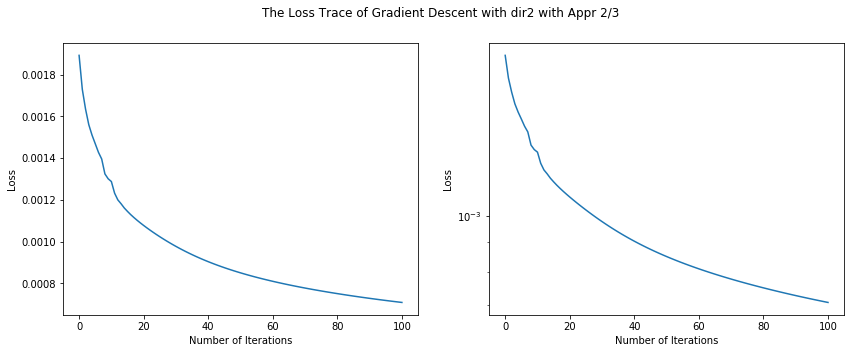

In [30]:
fig, ax = plt.subplots(1, 2, figsize=(14, 5));
ax[0].plot(loss_trace1);
fig.suptitle("The Loss Trace of Gradient Descent with dir2 with Appr 2/3");
ax[0].set_xlabel("Number of Iterations");
ax[0].set_ylabel("Loss")
ax[1].semilogy(loss_trace1)
ax[1].set_xlabel("Number of Iterations");
ax[1].set_ylabel("Loss")
plt.savefig("/Users/leiwanzhou/Desktop/GD_k30_appr2-3_1", dpi=200)

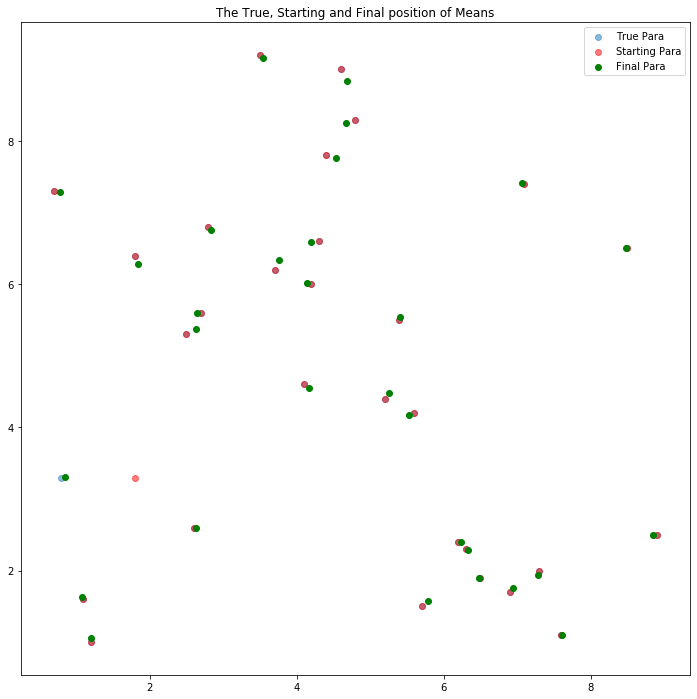

In [181]:
final_w1, final_mu1 = to2(final_para1, 30)
initial_w1, initial_mu1 = to2(initial_para1, 30)
plt.figure(figsize=(12, 12))
plt.scatter(mu_true[:, 0], mu_true[:, 1], label = 'True Para', alpha = '0.5')
plt.scatter(initial_mu1[:, 0], initial_mu1[:, 1], label = 'Starting Para', c = 'r', alpha = 0.5)
plt.scatter(final_mu1[:, 0], final_mu1[:, 1], label = 'Final Para', c = 'g')
plt.title("The True, Starting and Final position of Means")
plt.legend()

In [86]:
#perturb the value of the true parameters a little bit as the starting parameter value
k = 30;
initial_para = to1(mu_true, w_true);
initial_para[29:59] += .1;
initial_para[59:89] -= .1;
initial_w, initial_mu = to2(initial_para, 30);
loss(X, k, initial_mu, initial_w, ytruth)

0.0012351067029342183

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

1861
1862
1863
1864
1865
1866
1867
1868
1869
1870
1871
1872
1873
1874
1875
1876
1877
1878
1879
1880
1881
1882
1883
1884
1885
1886
1887
1888
1889
1890
1891
1892
1893
1894
1895
1896
1897
1898
1899
1900
1901
1902
1903
1904
1905
1906
1907
1908
1909
1910
1911
1912
1913
1914
1915
1916
1917
1918
1919
1920
1921
1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939
1940
1941
1942
1943
1944
1945
1946
1947
1948
1949
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
2024
2025
2026
2027
2028
2029
2030
2031
2032
2033
2034
2035
2036
2037
2038
2039
2040
2041
2042
2043
2044
2045
2046
2047
2048
2049
2050
2051
2052
2053
2054
2055
2056
2057
2058
2059
2060


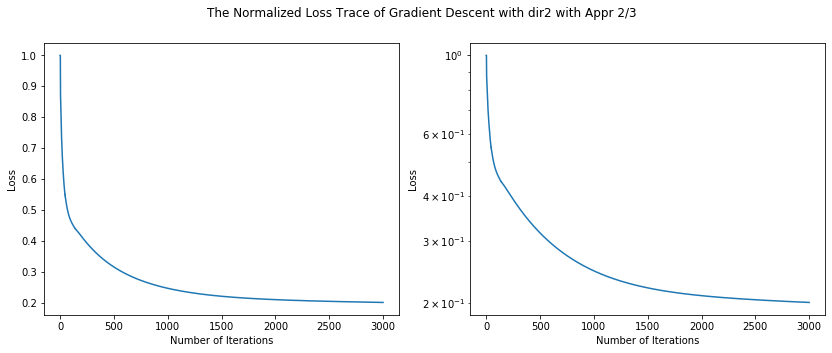

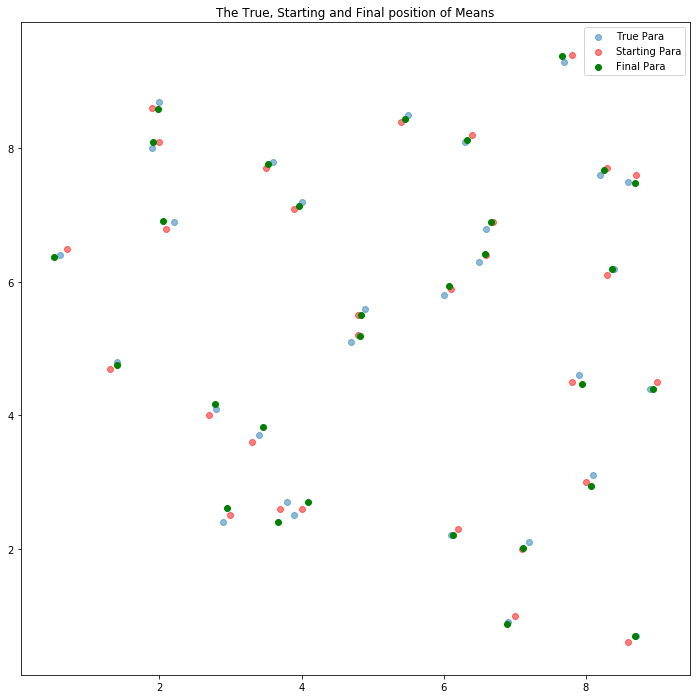

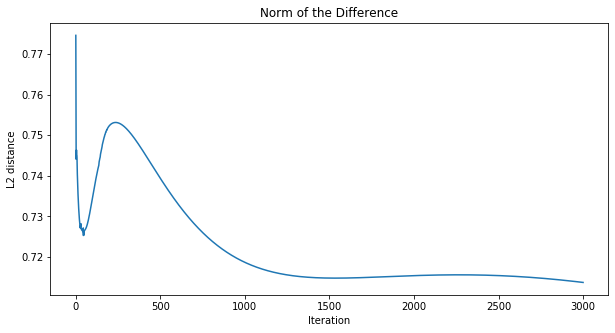

In [92]:
loss_trace, final_para, diff_norm = GD_dir2(31, k, initial_para, to1(mu_true, w_true), ytruth, 0.1, 3000)

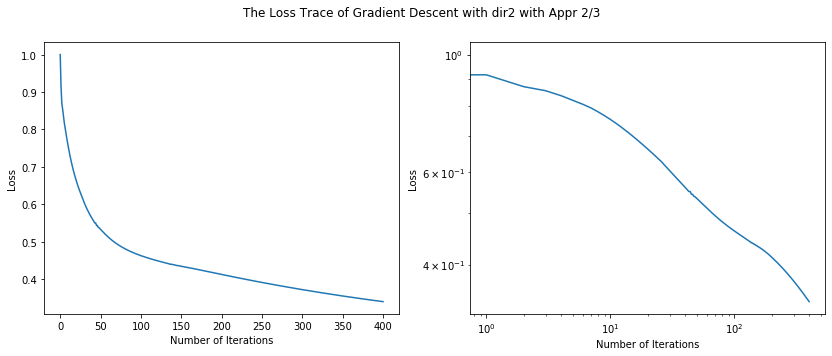

In [68]:

fig, ax = plt.subplots(1, 2, figsize=(14, 5));
ax[0].plot(loss_trace/loss_trace[0]);
fig.suptitle("The Loss Trace of Gradient Descent with dir2 with Appr 2/3");
ax[0].set_xlabel("Number of Iterations");
ax[0].set_ylabel("Loss")
ax[1].loglog(loss_trace/loss_trace[0])
ax[1].set_xlabel("Number of Iterations");
ax[1].set_ylabel("Loss")
plt.savefig("/Users/leiwanzhou/Desktop/GD_k30_appr2-3_2", dpi=200)

In [69]:
final_w, final_mu = to2(final_para, 30)
initial_w, initial_mu = to2(initial_para, 30)

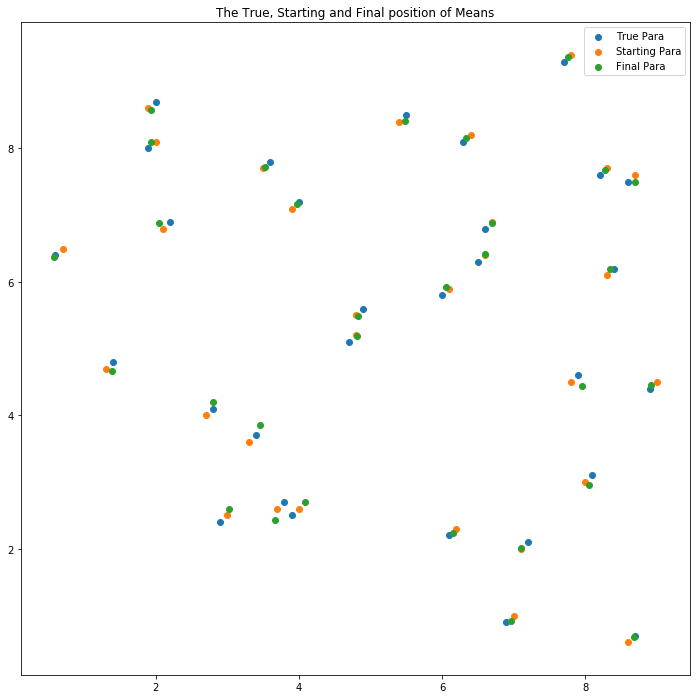

In [70]:
plt.figure(figsize=(12, 12))
plt.scatter(mu_true[:, 0], mu_true[:, 1], label = 'True Para')
plt.scatter(initial_mu[:, 0], initial_mu[:, 1], label = 'Starting Para')
plt.scatter(final_mu[:, 0], final_mu[:, 1], label = 'Final Para')
plt.title("The True, Starting and Final position of Means")
plt.legend()

Time each iteration: 0.015392318278551101


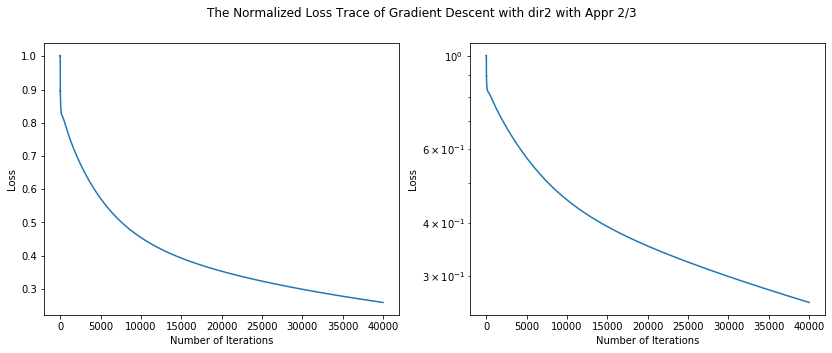

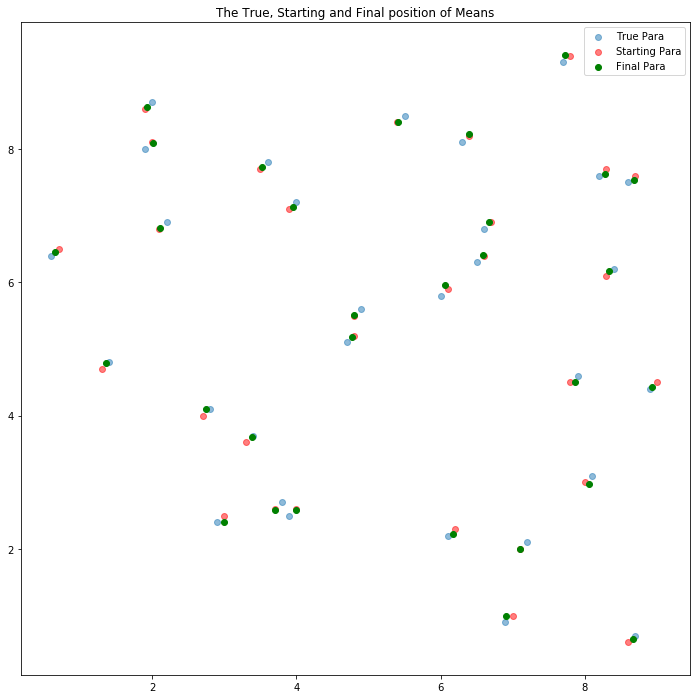

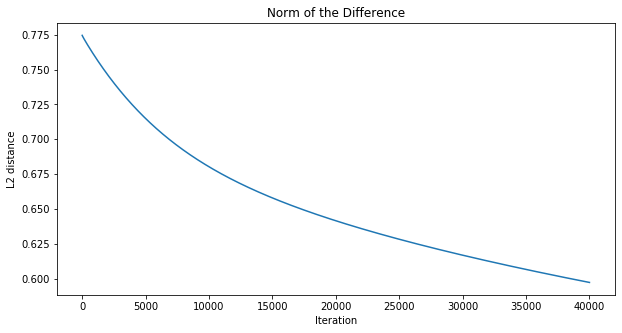

In [64]:
std_losstrace, std_finalpara, std_diffnorm = std_GD(31, k, initial_para, to1(mu_true, w_true), ytruth, 0.055, 40000);

In [ ]:
# _,log = ot.lp.emd(Peq, Peq_true, costM, numItermax=1000000, log=True)
#     cost = log['cost']
#     u = log['u']

# log['cost'] is the objective function
# log['u'] is the dJ/ d rho